In [45]:
import numpy as np
import csv
import pickle
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Input data

In [46]:
image_names = []
labels = []

csv_file = './train.csv'

with open(csv_file, 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)
    for row in csv_reader:
        image_names.append(row[0])
        labels.append(int(row[1]))

print("Image Names:", image_names)
print("Labels:", labels)
for i in range(10):
    print("Number of images with label", i, ":", labels.count(i))

Image Names: ['00016cd.jpg', '0001808.jpg', '0002399.jpg', '0003973.jpg', '00061cc.jpg', '0007365.jpg', '0007d24.jpg', '0009157.jpg', '000a239.jpg', '000a477.jpg', '000dde3.jpg', '000e993.jpg', '000edf2.jpg', '000ff7b.jpg', '00107cf.jpg', '0016c39.jpg', '0016e7f.jpg', '00170f0.jpg', '0018991.jpg', '0019531.jpg', '001ab02.jpg', '001adfd.jpg', '001b3ac.jpg', '001bb0e.jpg', '001e6f1.jpg', '00228b0.jpg', '0023eda.jpg', '00253a0.jpg', '00292ef.jpg', '0029b8f.jpg', '002b5c8.jpg', '002b66d.jpg', '002cd0a.jpg', '002e96a.jpg', '002ecbf.jpg', '003118b.jpg', '003518c.jpg', '003686e.jpg', '0037e1f.jpg', '0038889.jpg', '0039f84.jpg', '003a294.jpg', '003a894.jpg', '003adab.jpg', '003d4bb.jpg', '003e8ac.jpg', '003eb9e.jpg', '0040cf6.jpg', '0041444.jpg', '00433dd.jpg', '0044e44.jpg', '0044e9c.jpg', '004547b.jpg', '004612c.jpg', '00463f5.jpg', '00472fe.jpg', '0048e10.jpg', '0049e4b.jpg', '004a017.jpg', '004cb37.jpg', '004ce59.jpg', '004e43f.jpg', '004f0ef.jpg', '004f3f9.jpg', '00505d0.jpg', '0051b4a.jp

# Visualization

Images with label 0 : ['000a239.jpg' '001e6f1.jpg' '0023eda.jpg' ... 'd58f3c1.jpg' 'd590edf.jpg'
 'd59d147.jpg']


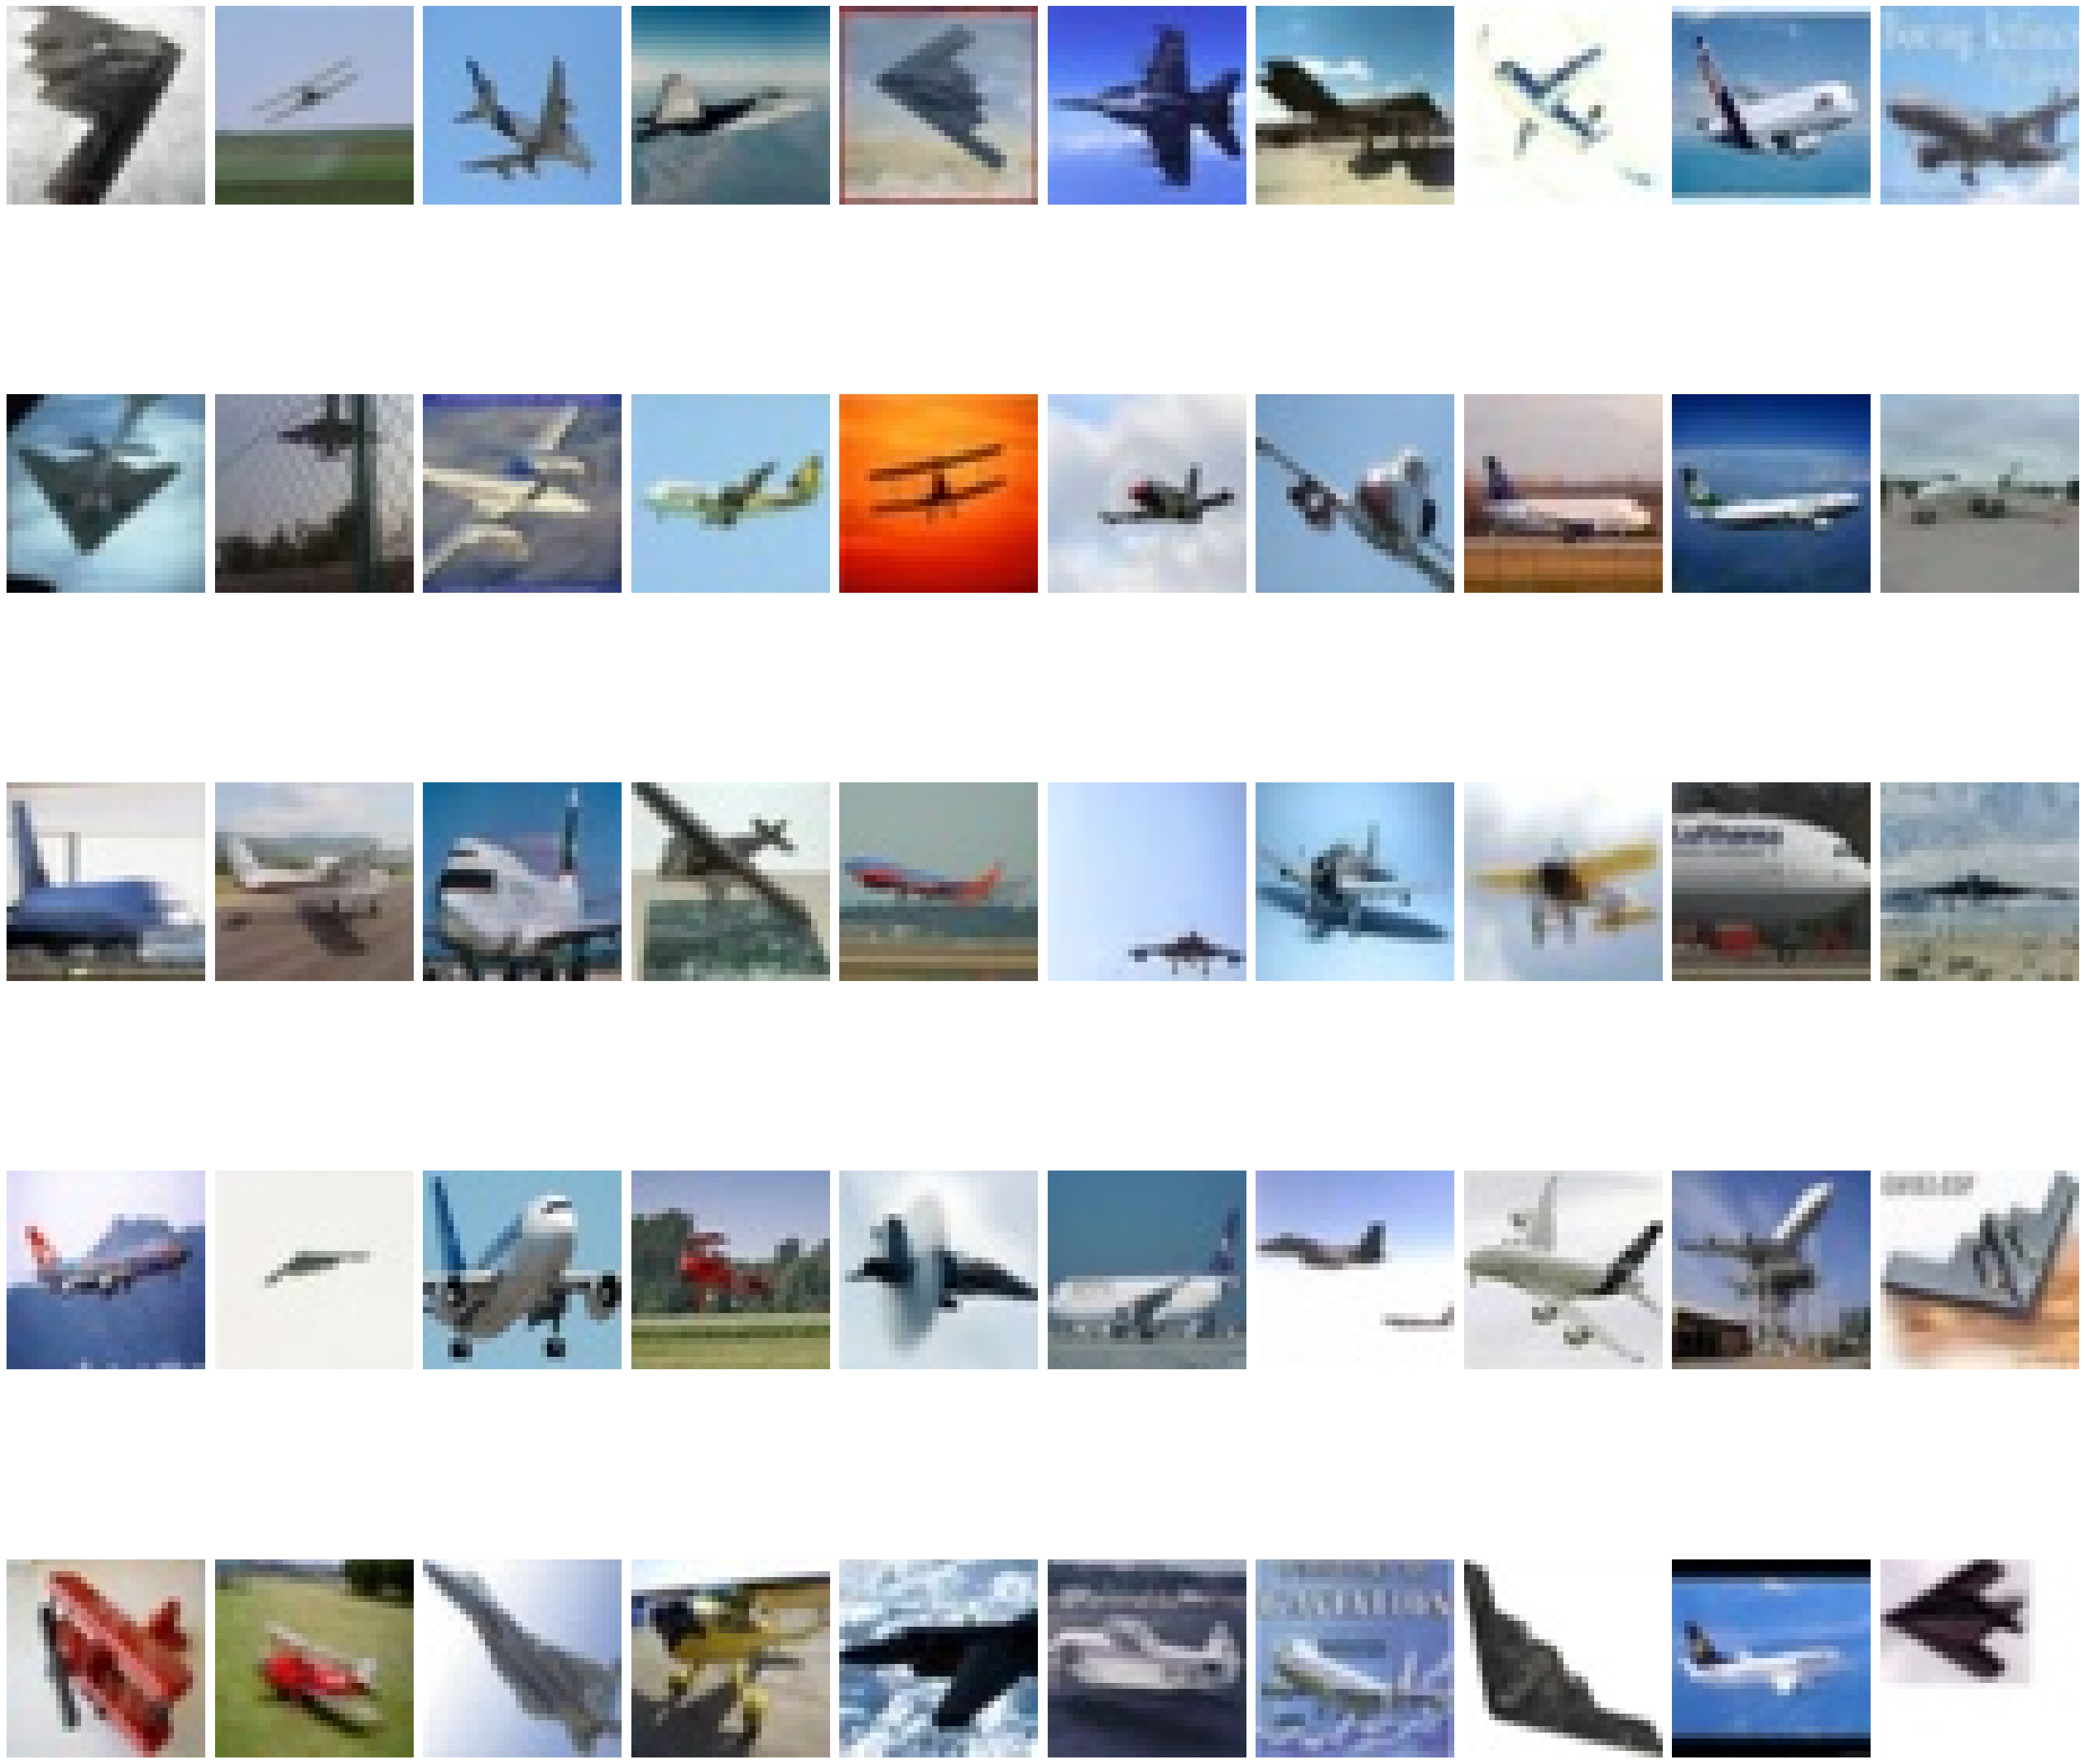

Images with label 1 : ['0002399.jpg' '0016c39.jpg' '0016e7f.jpg' ... 'd587280.jpg' 'd589fd5.jpg'
 'd58b29c.jpg']


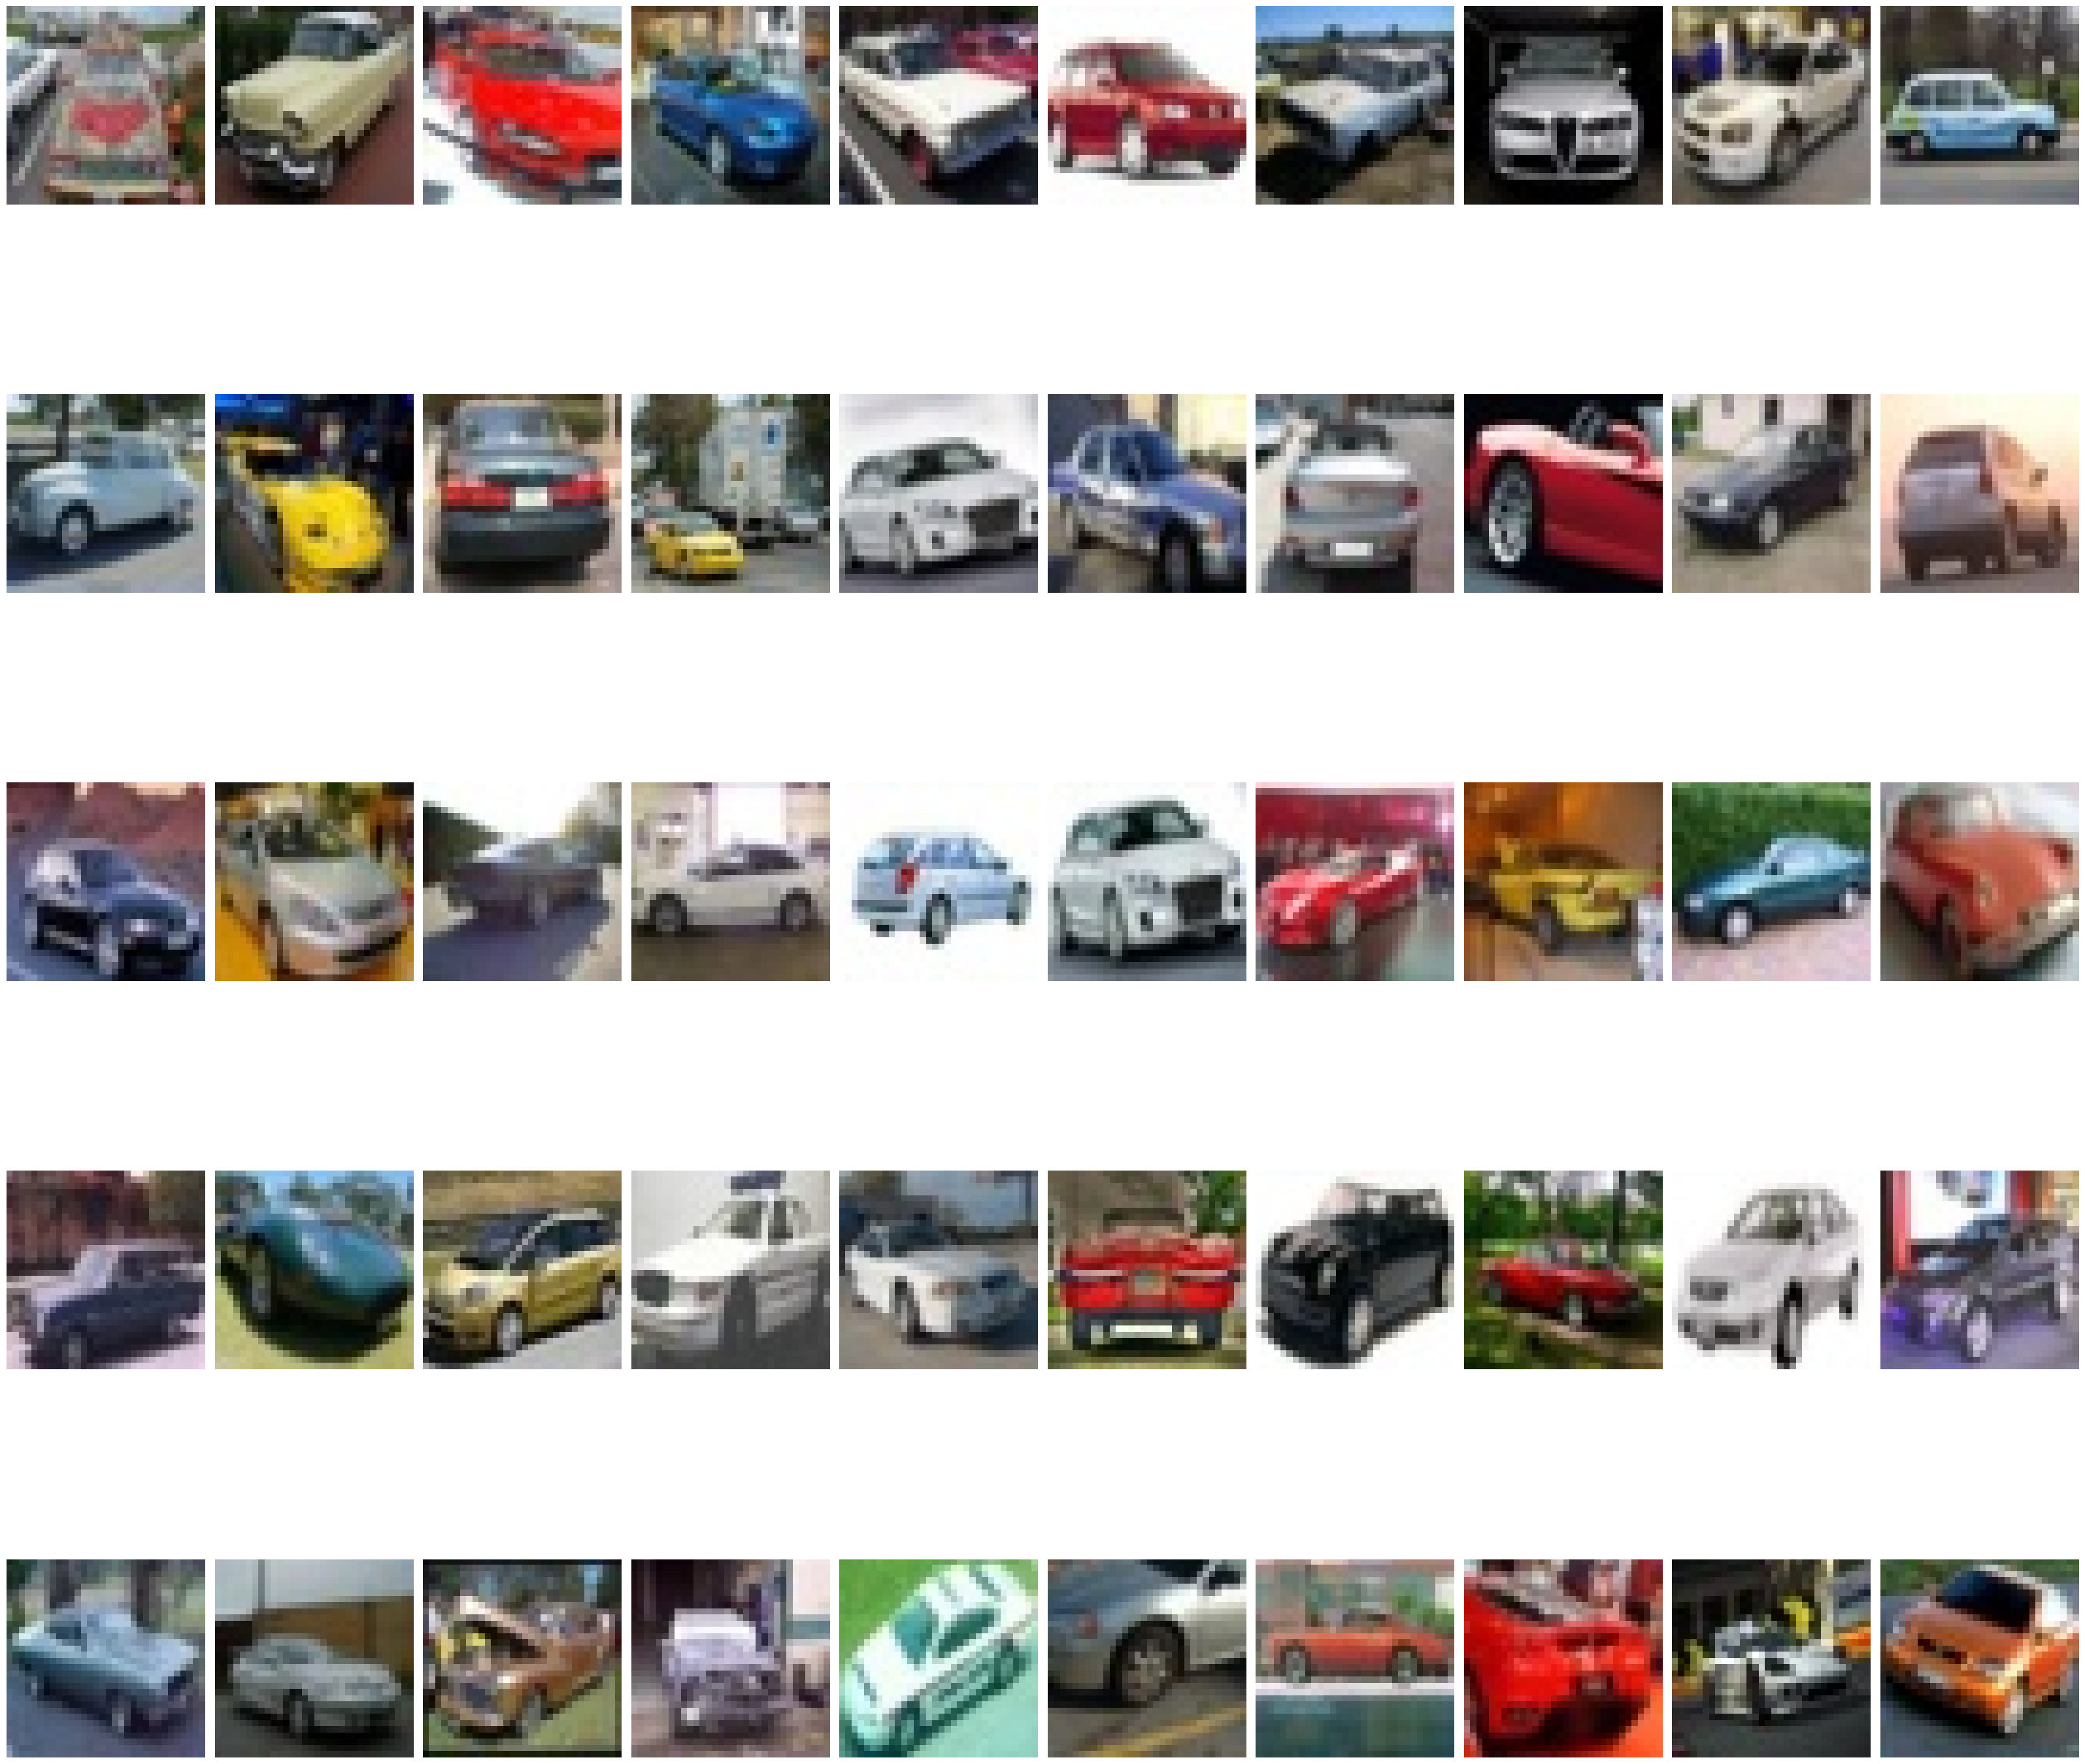

Images with label 2 : ['0001808.jpg' '001b3ac.jpg' '001bb0e.jpg' ... 'd57cbbe.jpg' 'd585bce.jpg'
 'd591075.jpg']


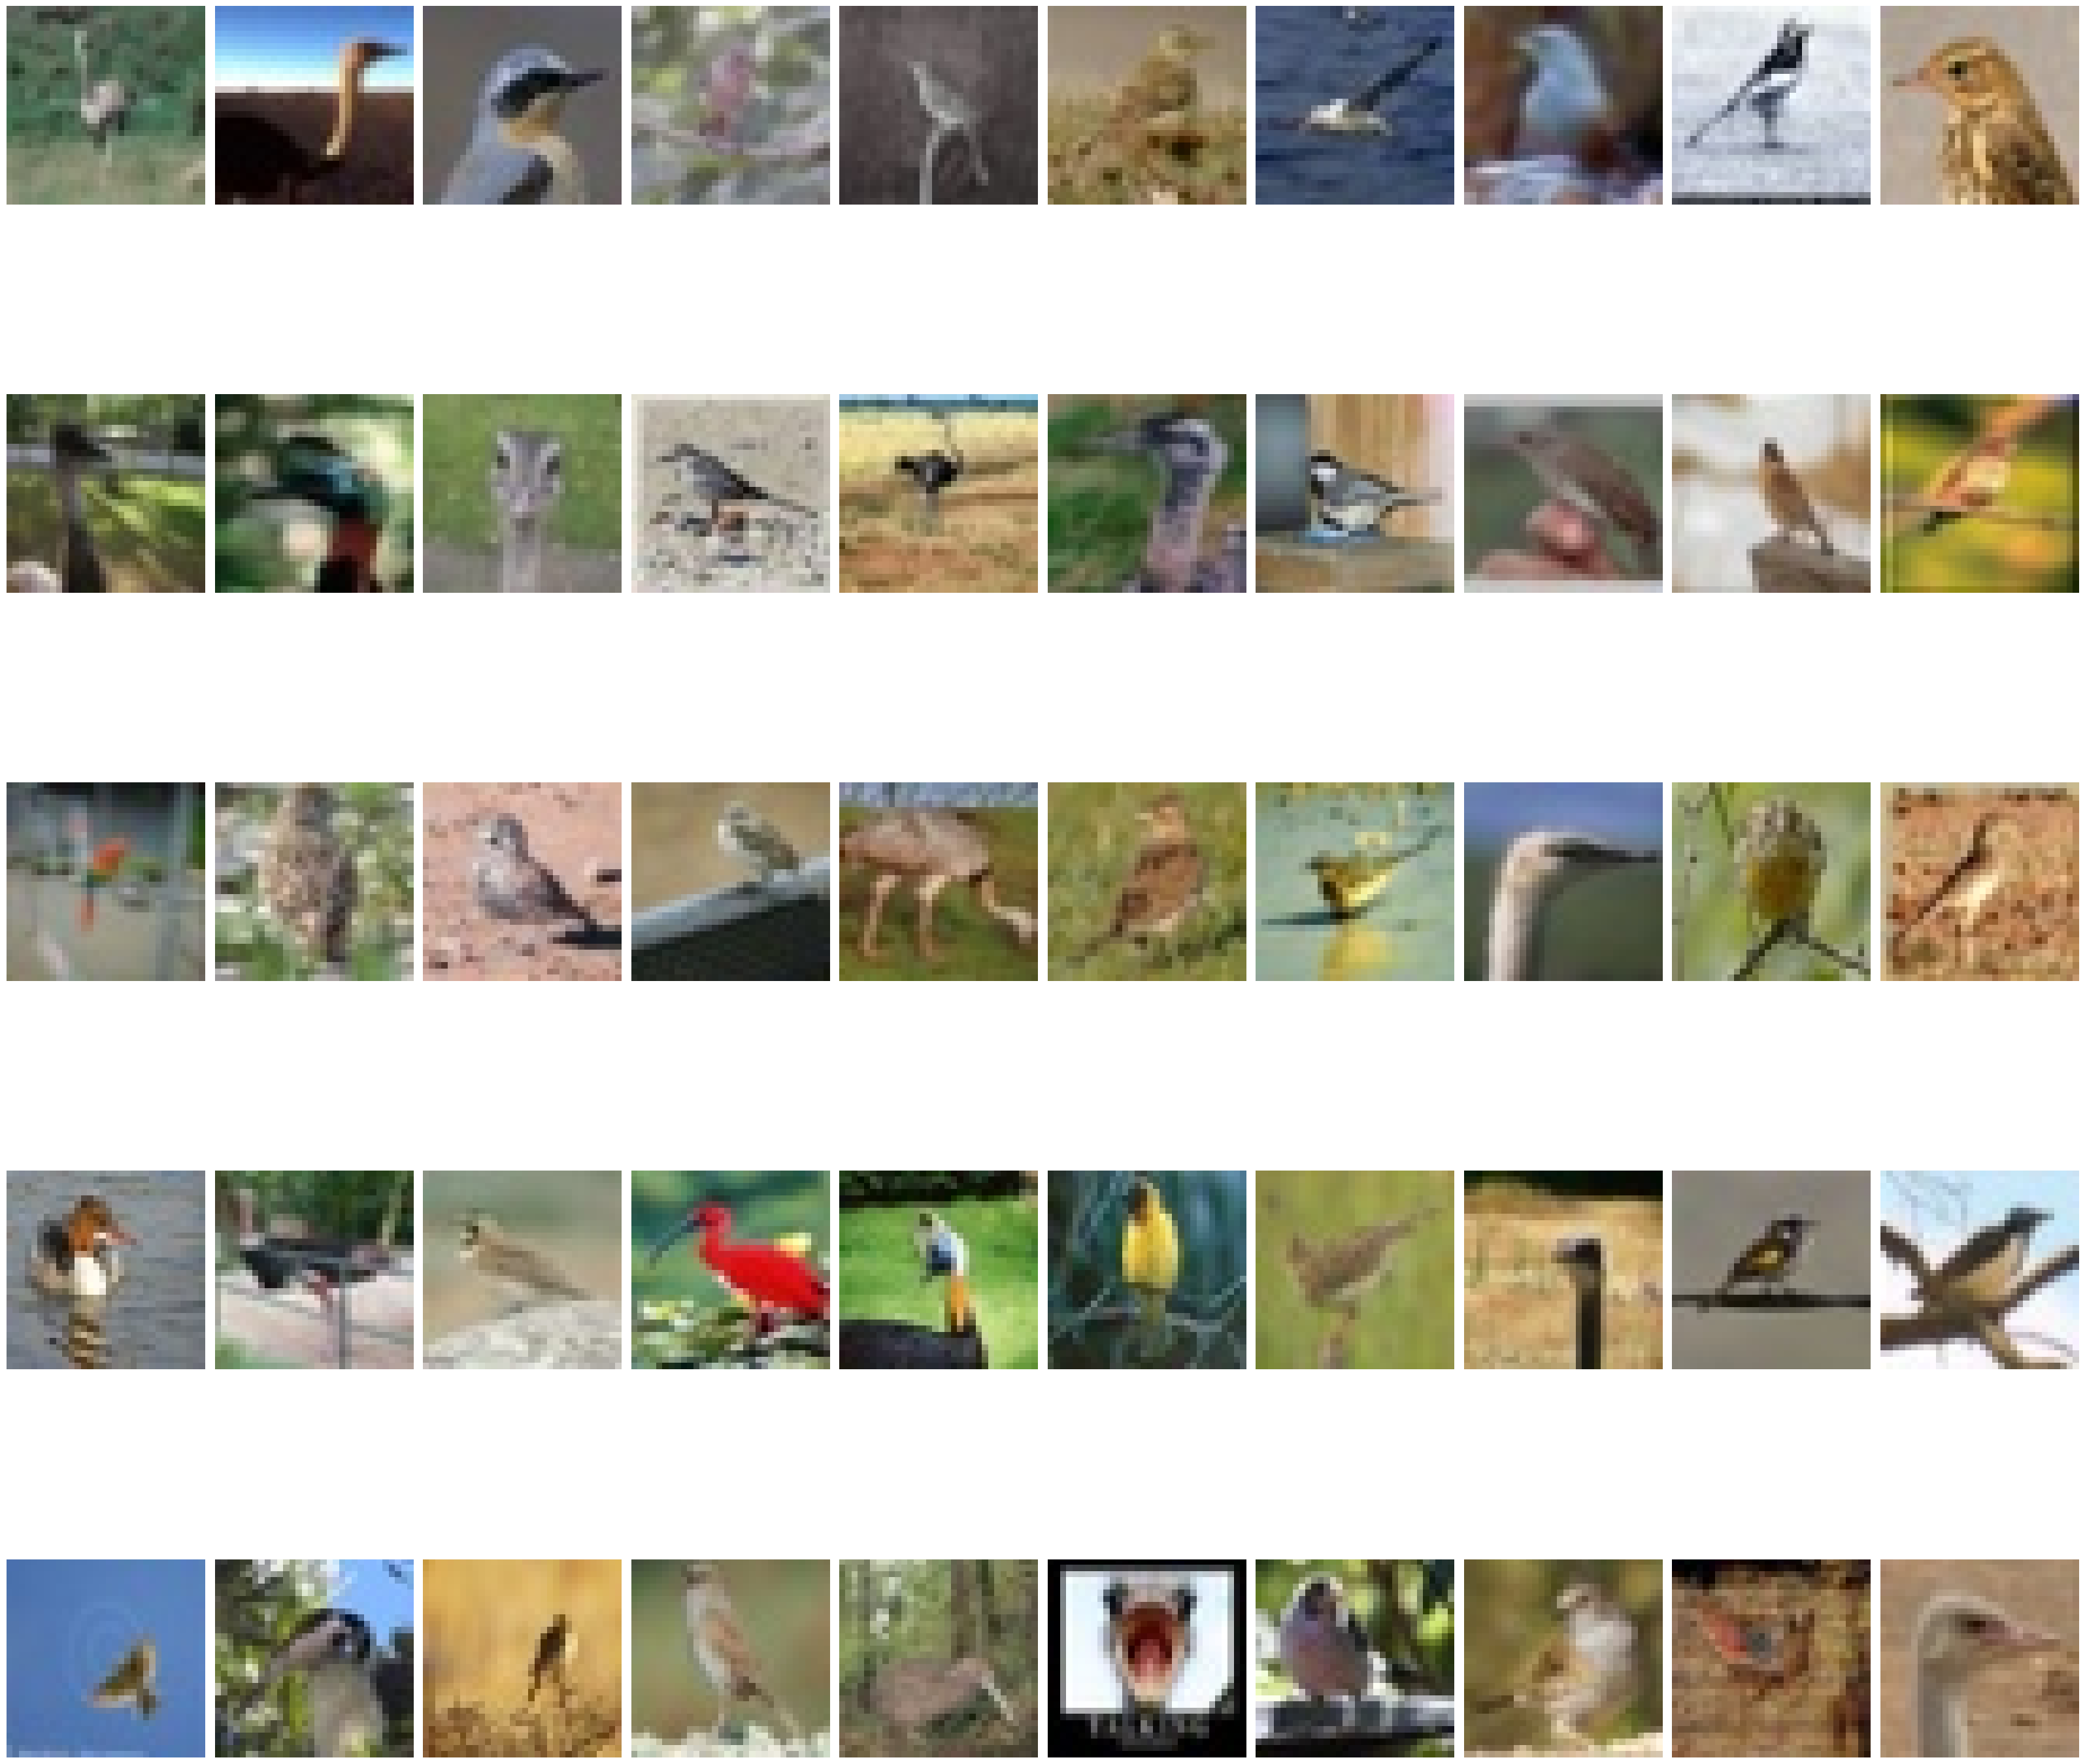

Images with label 3 : ['0003973.jpg' '000dde3.jpg' '000e993.jpg' ... 'd57cef8.jpg' 'd591445.jpg'
 'd59432a.jpg']


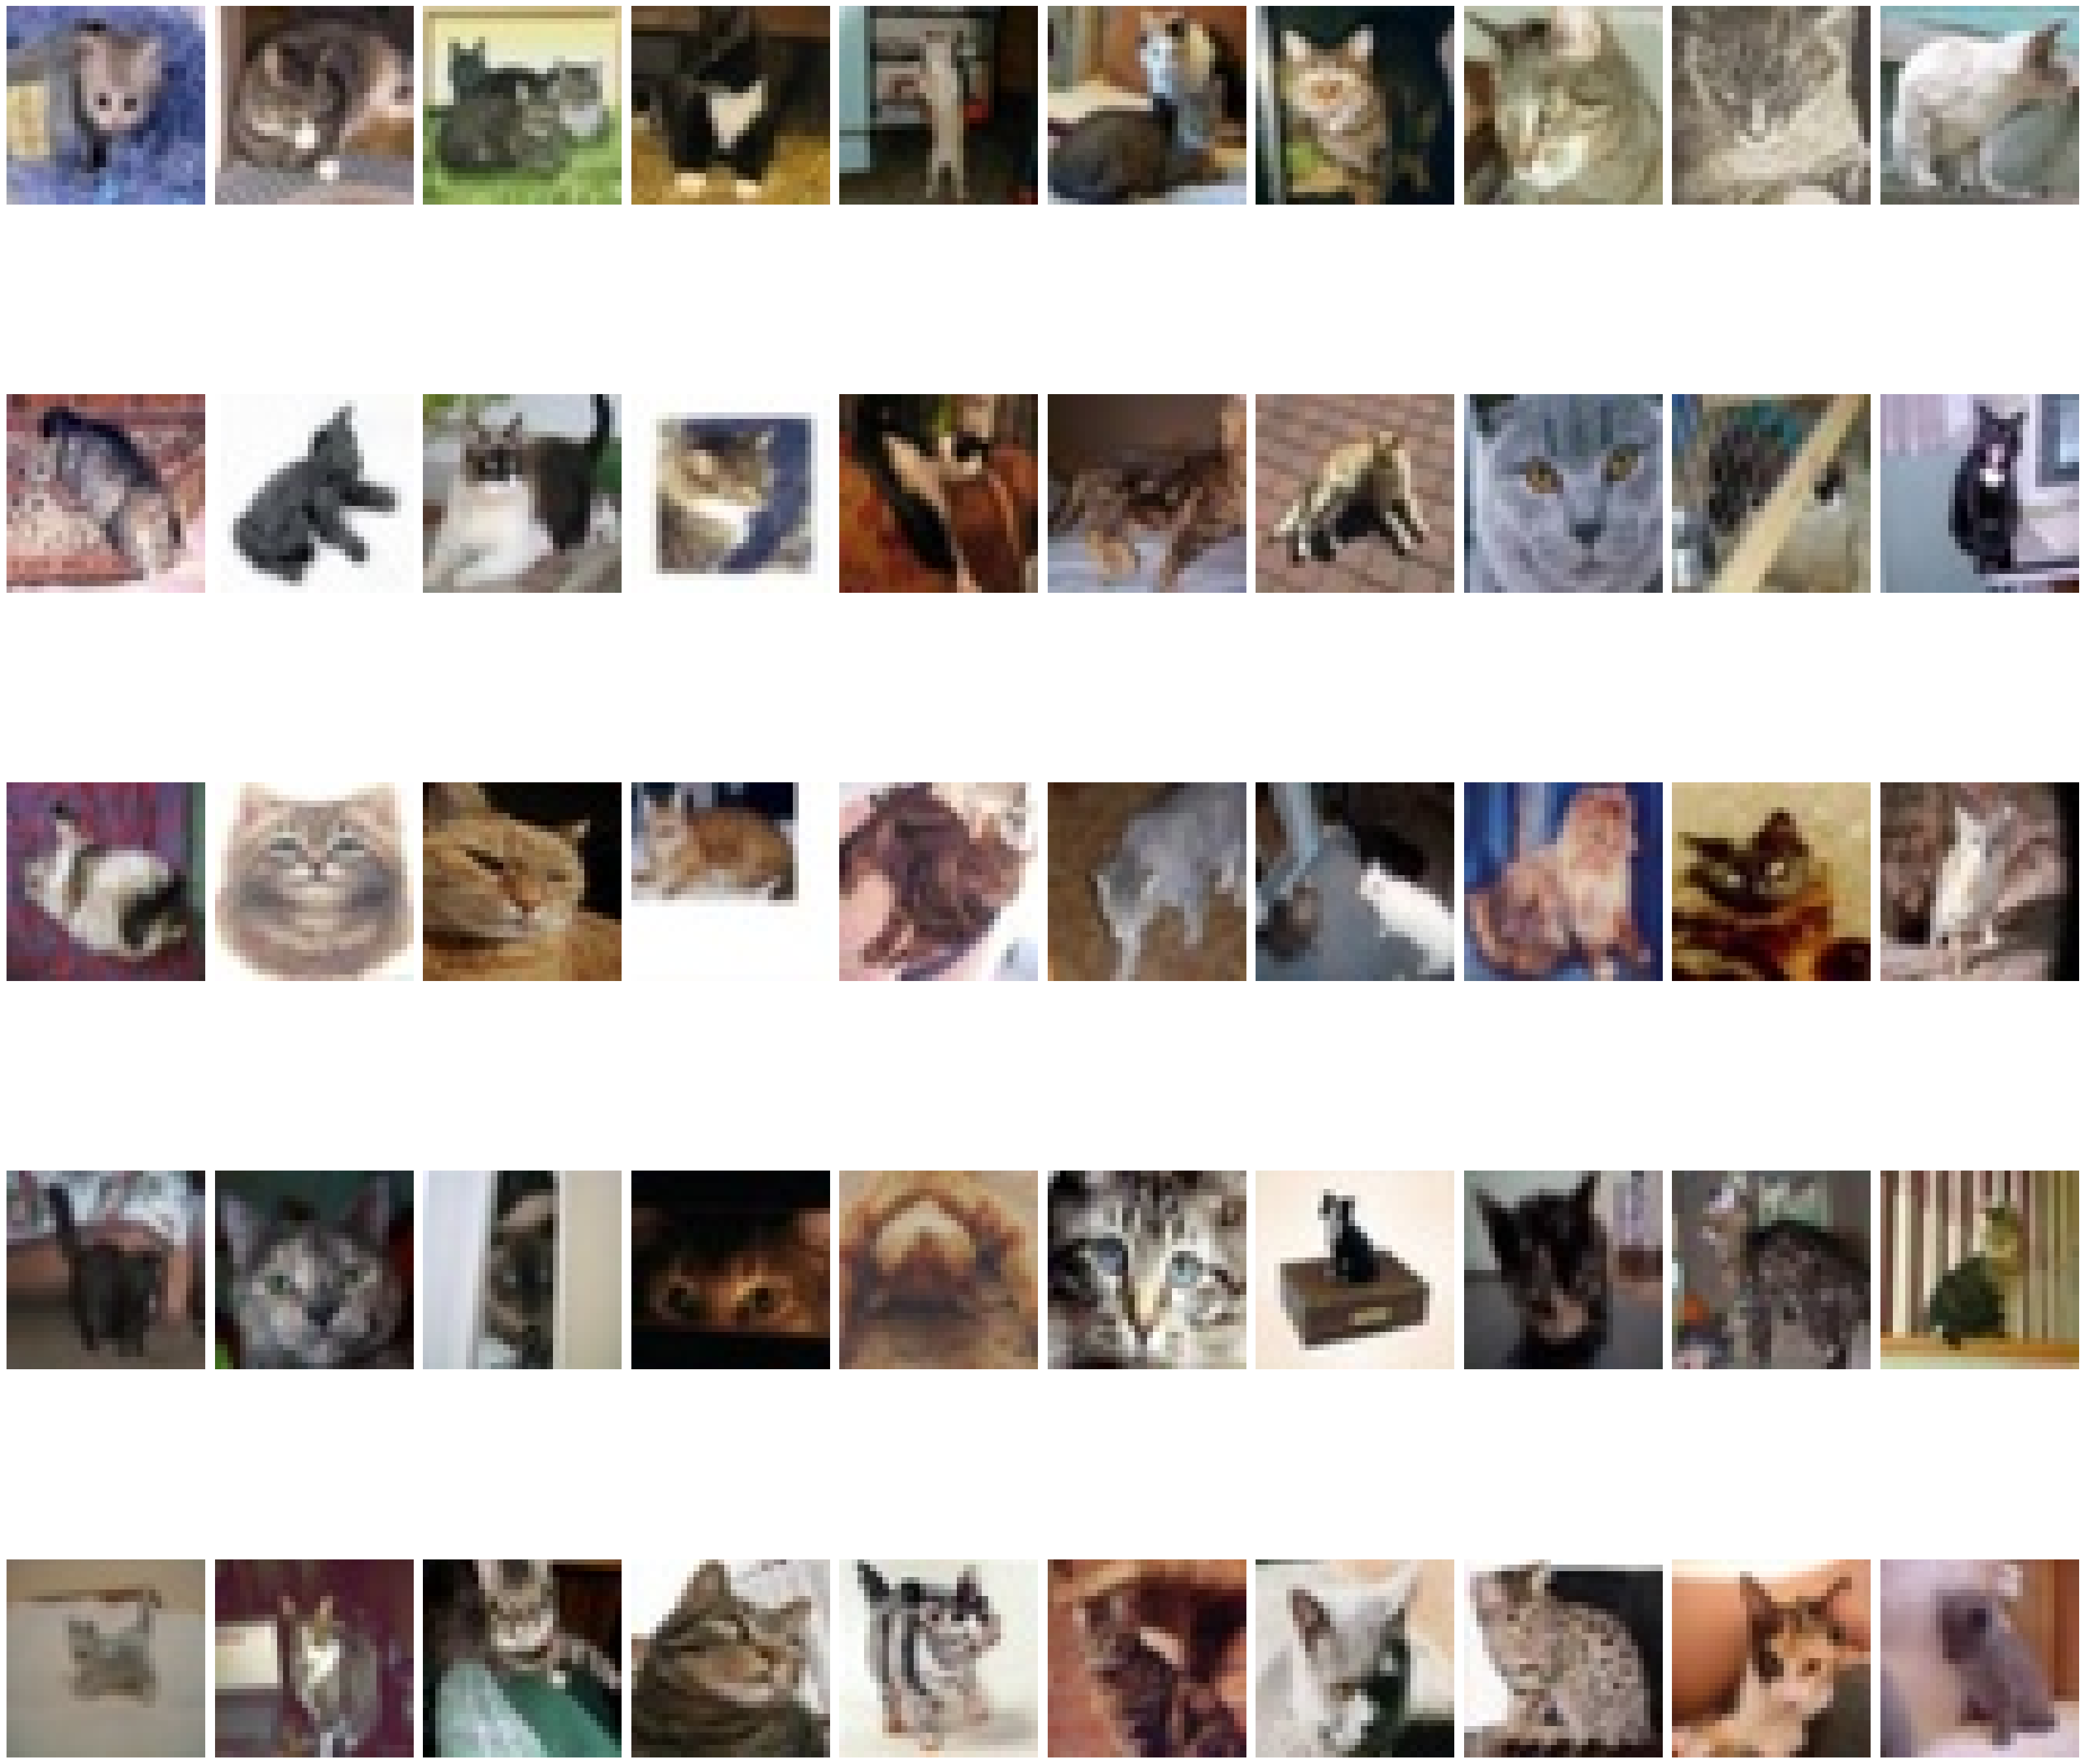

Images with label 4 : ['00061cc.jpg' '00107cf.jpg' '00228b0.jpg' ... 'd56fb7d.jpg' 'd574577.jpg'
 'd588426.jpg']


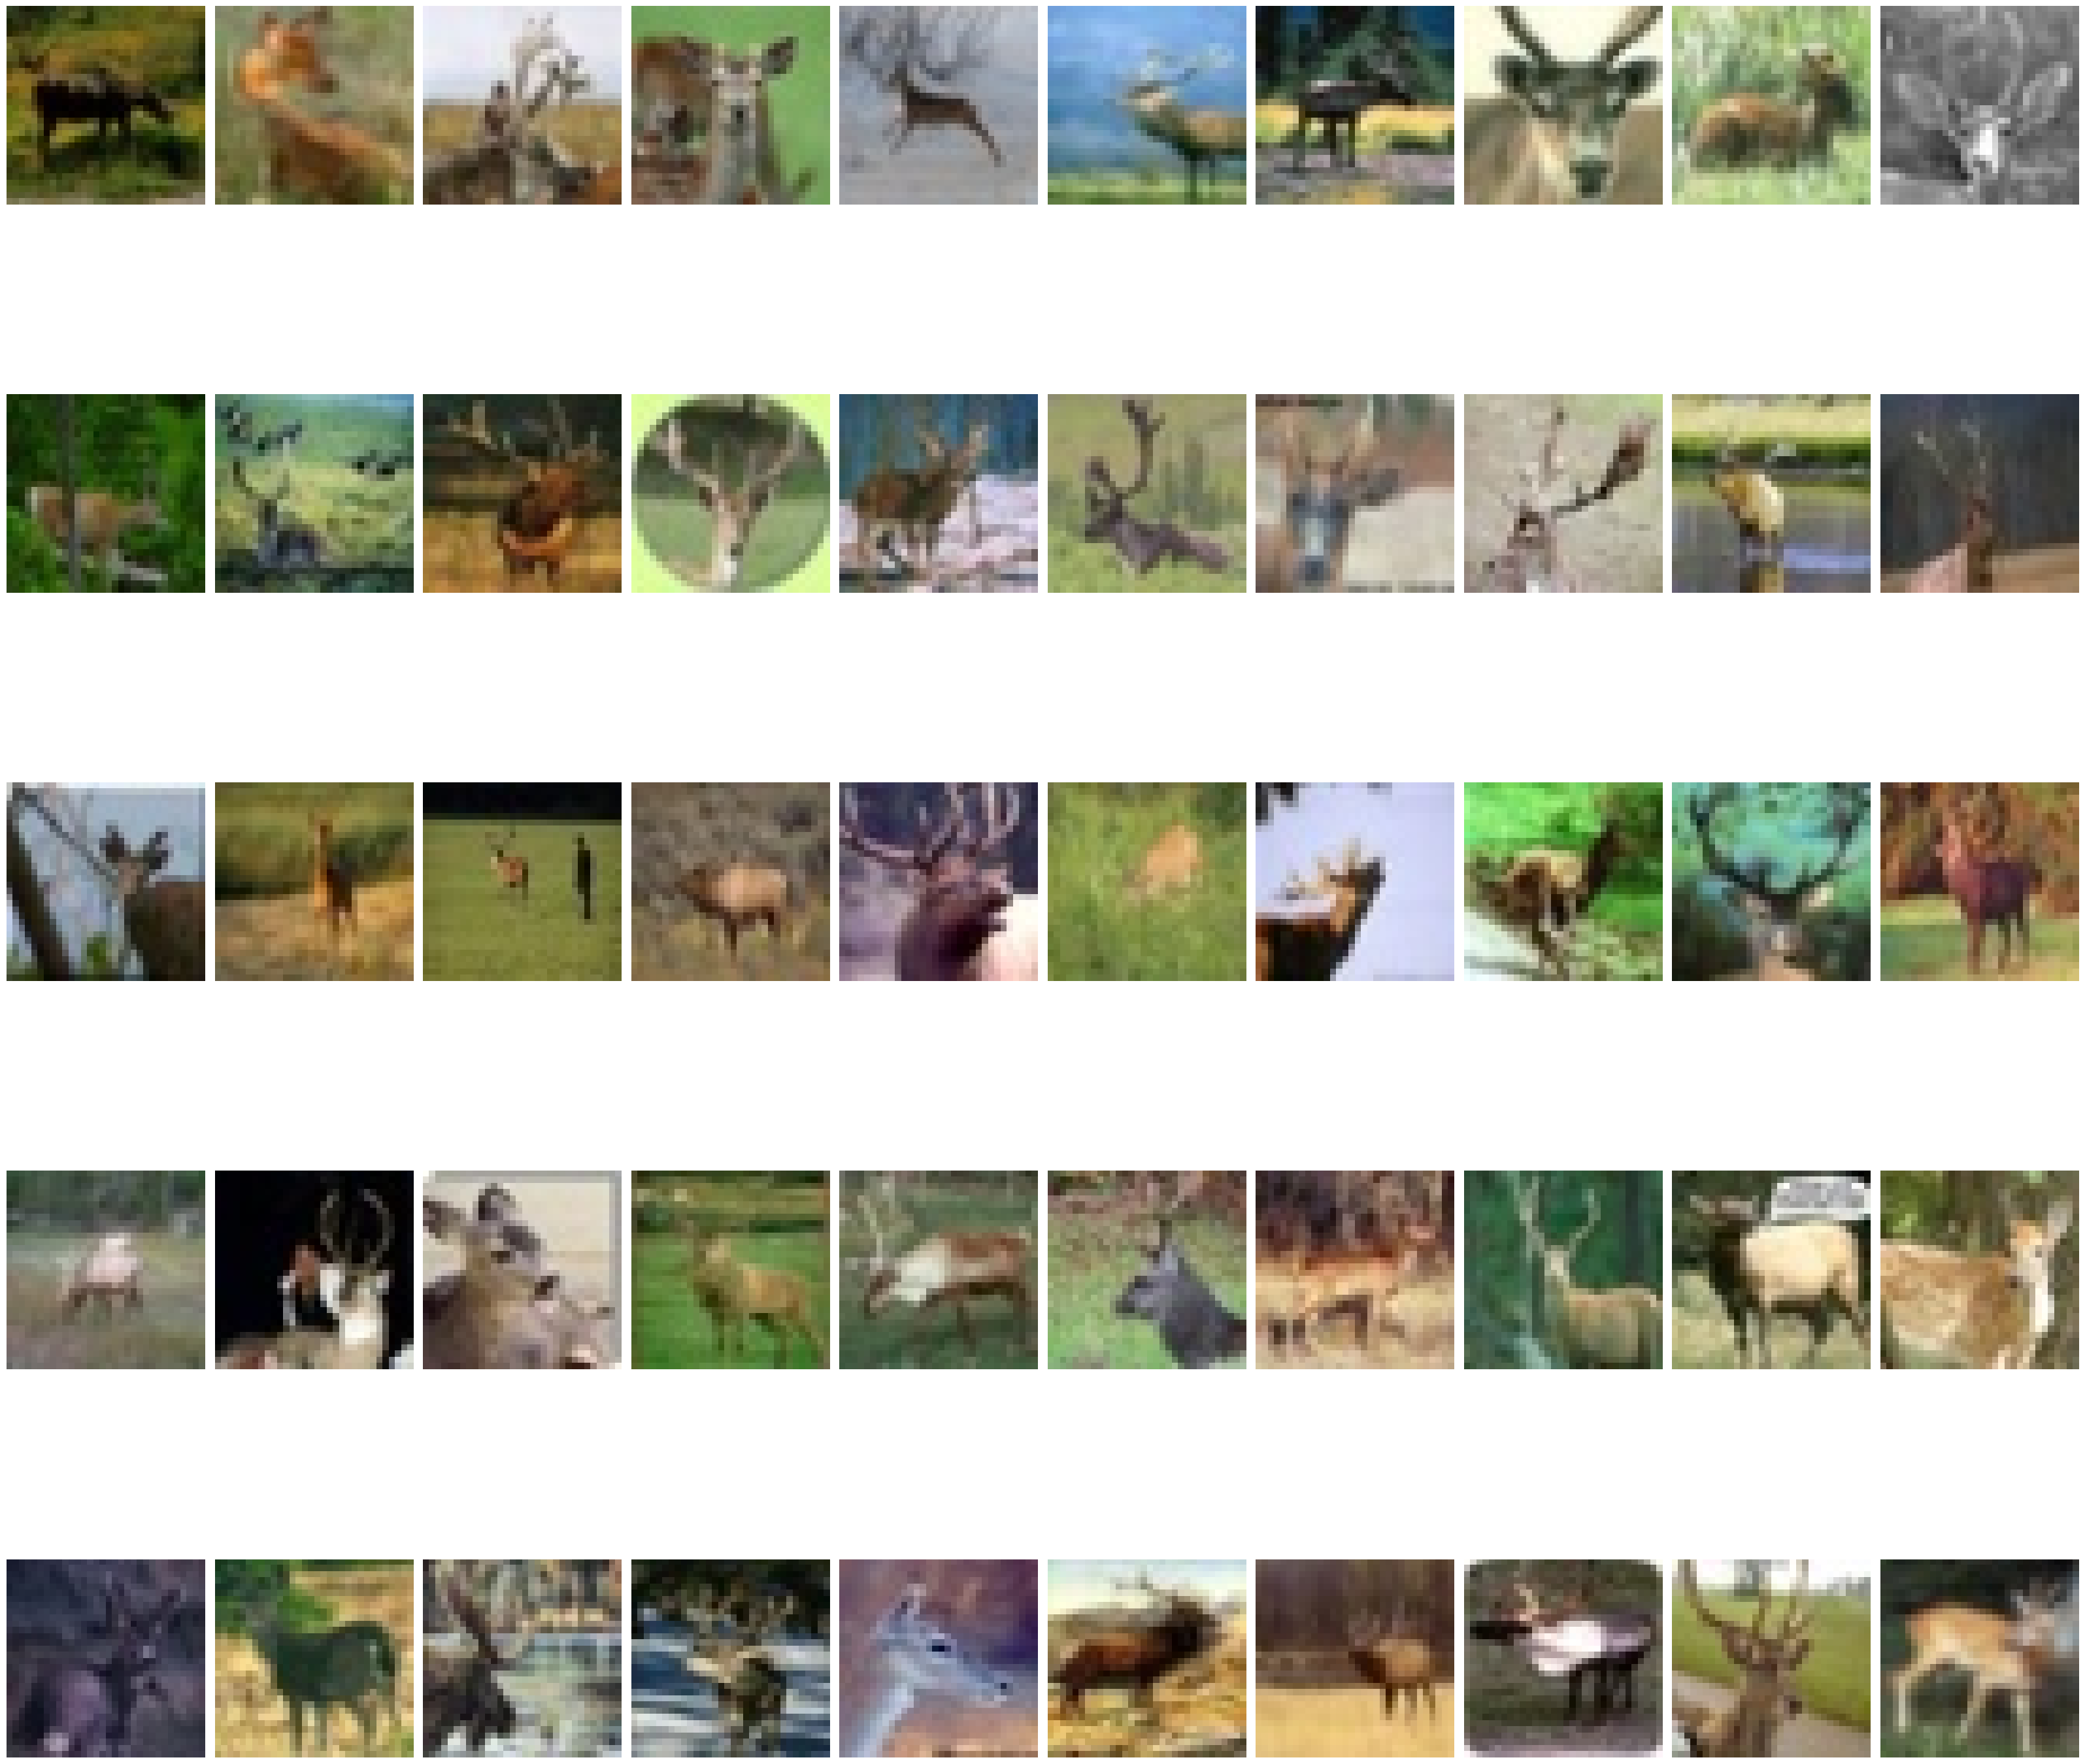

Images with label 5 : ['0007365.jpg' '002ecbf.jpg' '003518c.jpg' ... 'd5756df.jpg' 'd594ea3.jpg'
 'd59a4c9.jpg']


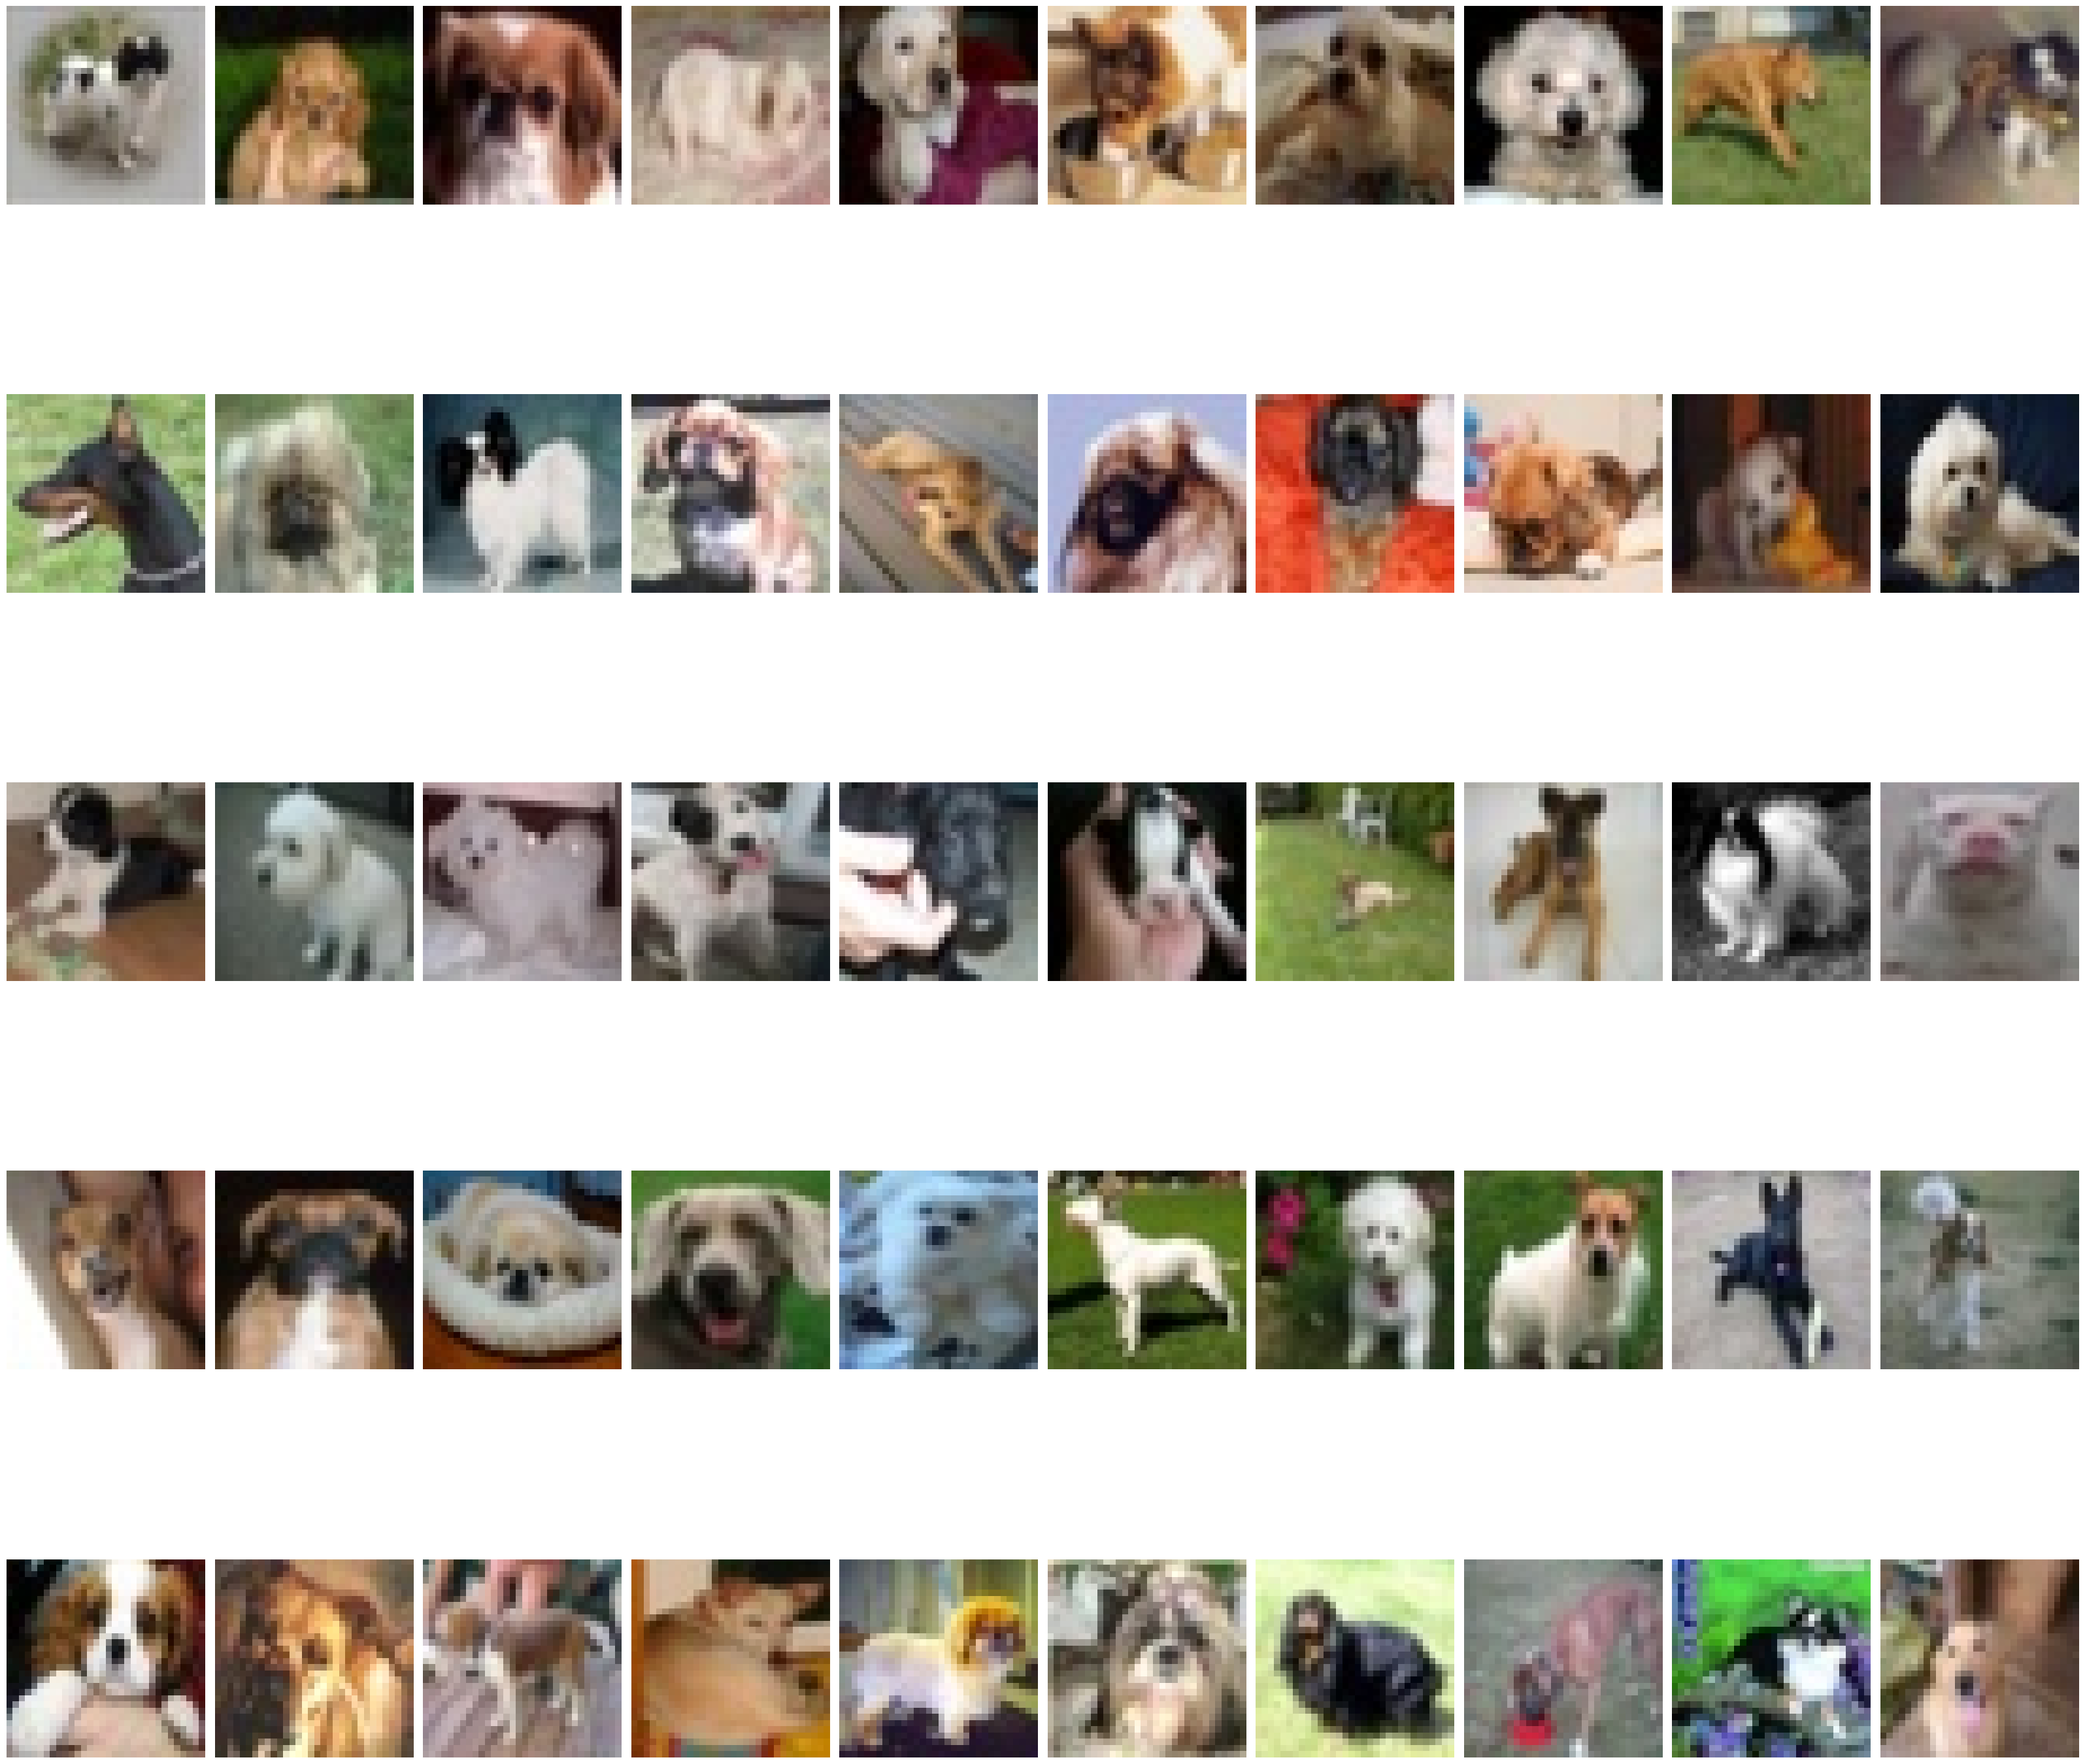

Images with label 6 : ['00016cd.jpg' '0009157.jpg' '000a477.jpg' ... 'd582e46.jpg' 'd586dad.jpg'
 'd5961b3.jpg']


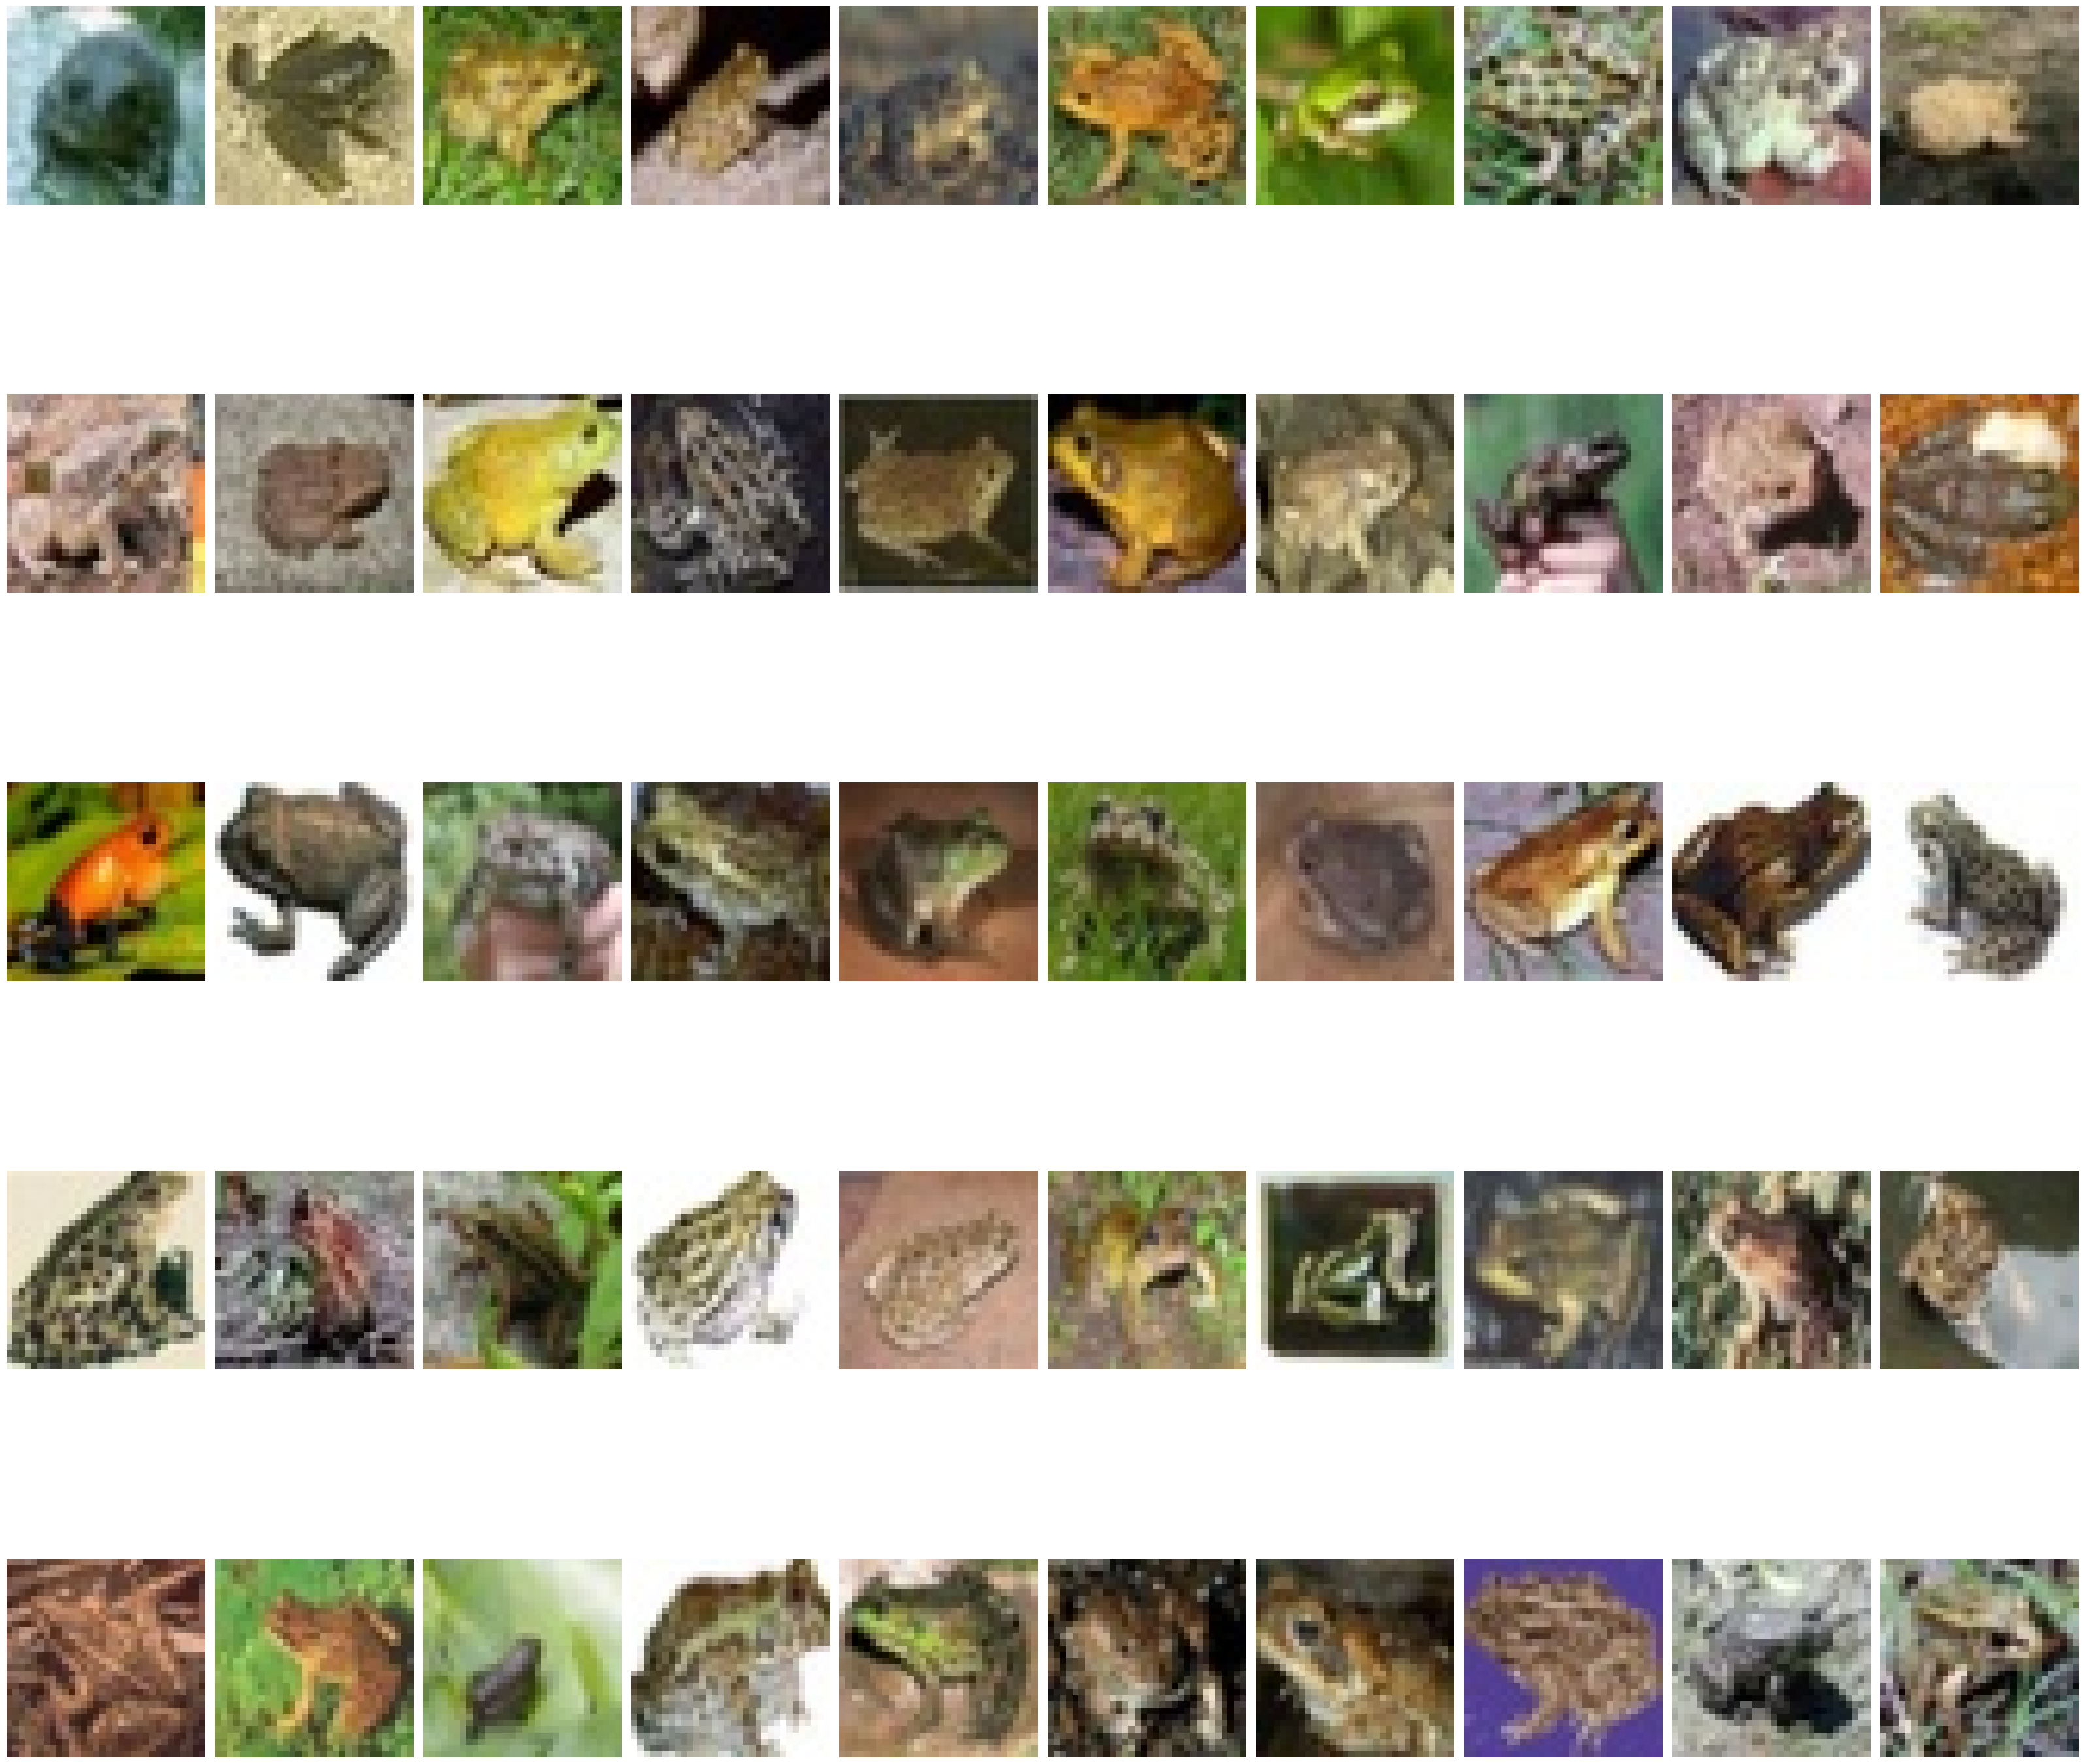

Images with label 7 : ['0007d24.jpg' '000ff7b.jpg' '00170f0.jpg' ... 'd57d79c.jpg' 'd57e0e4.jpg'
 'd5992c0.jpg']


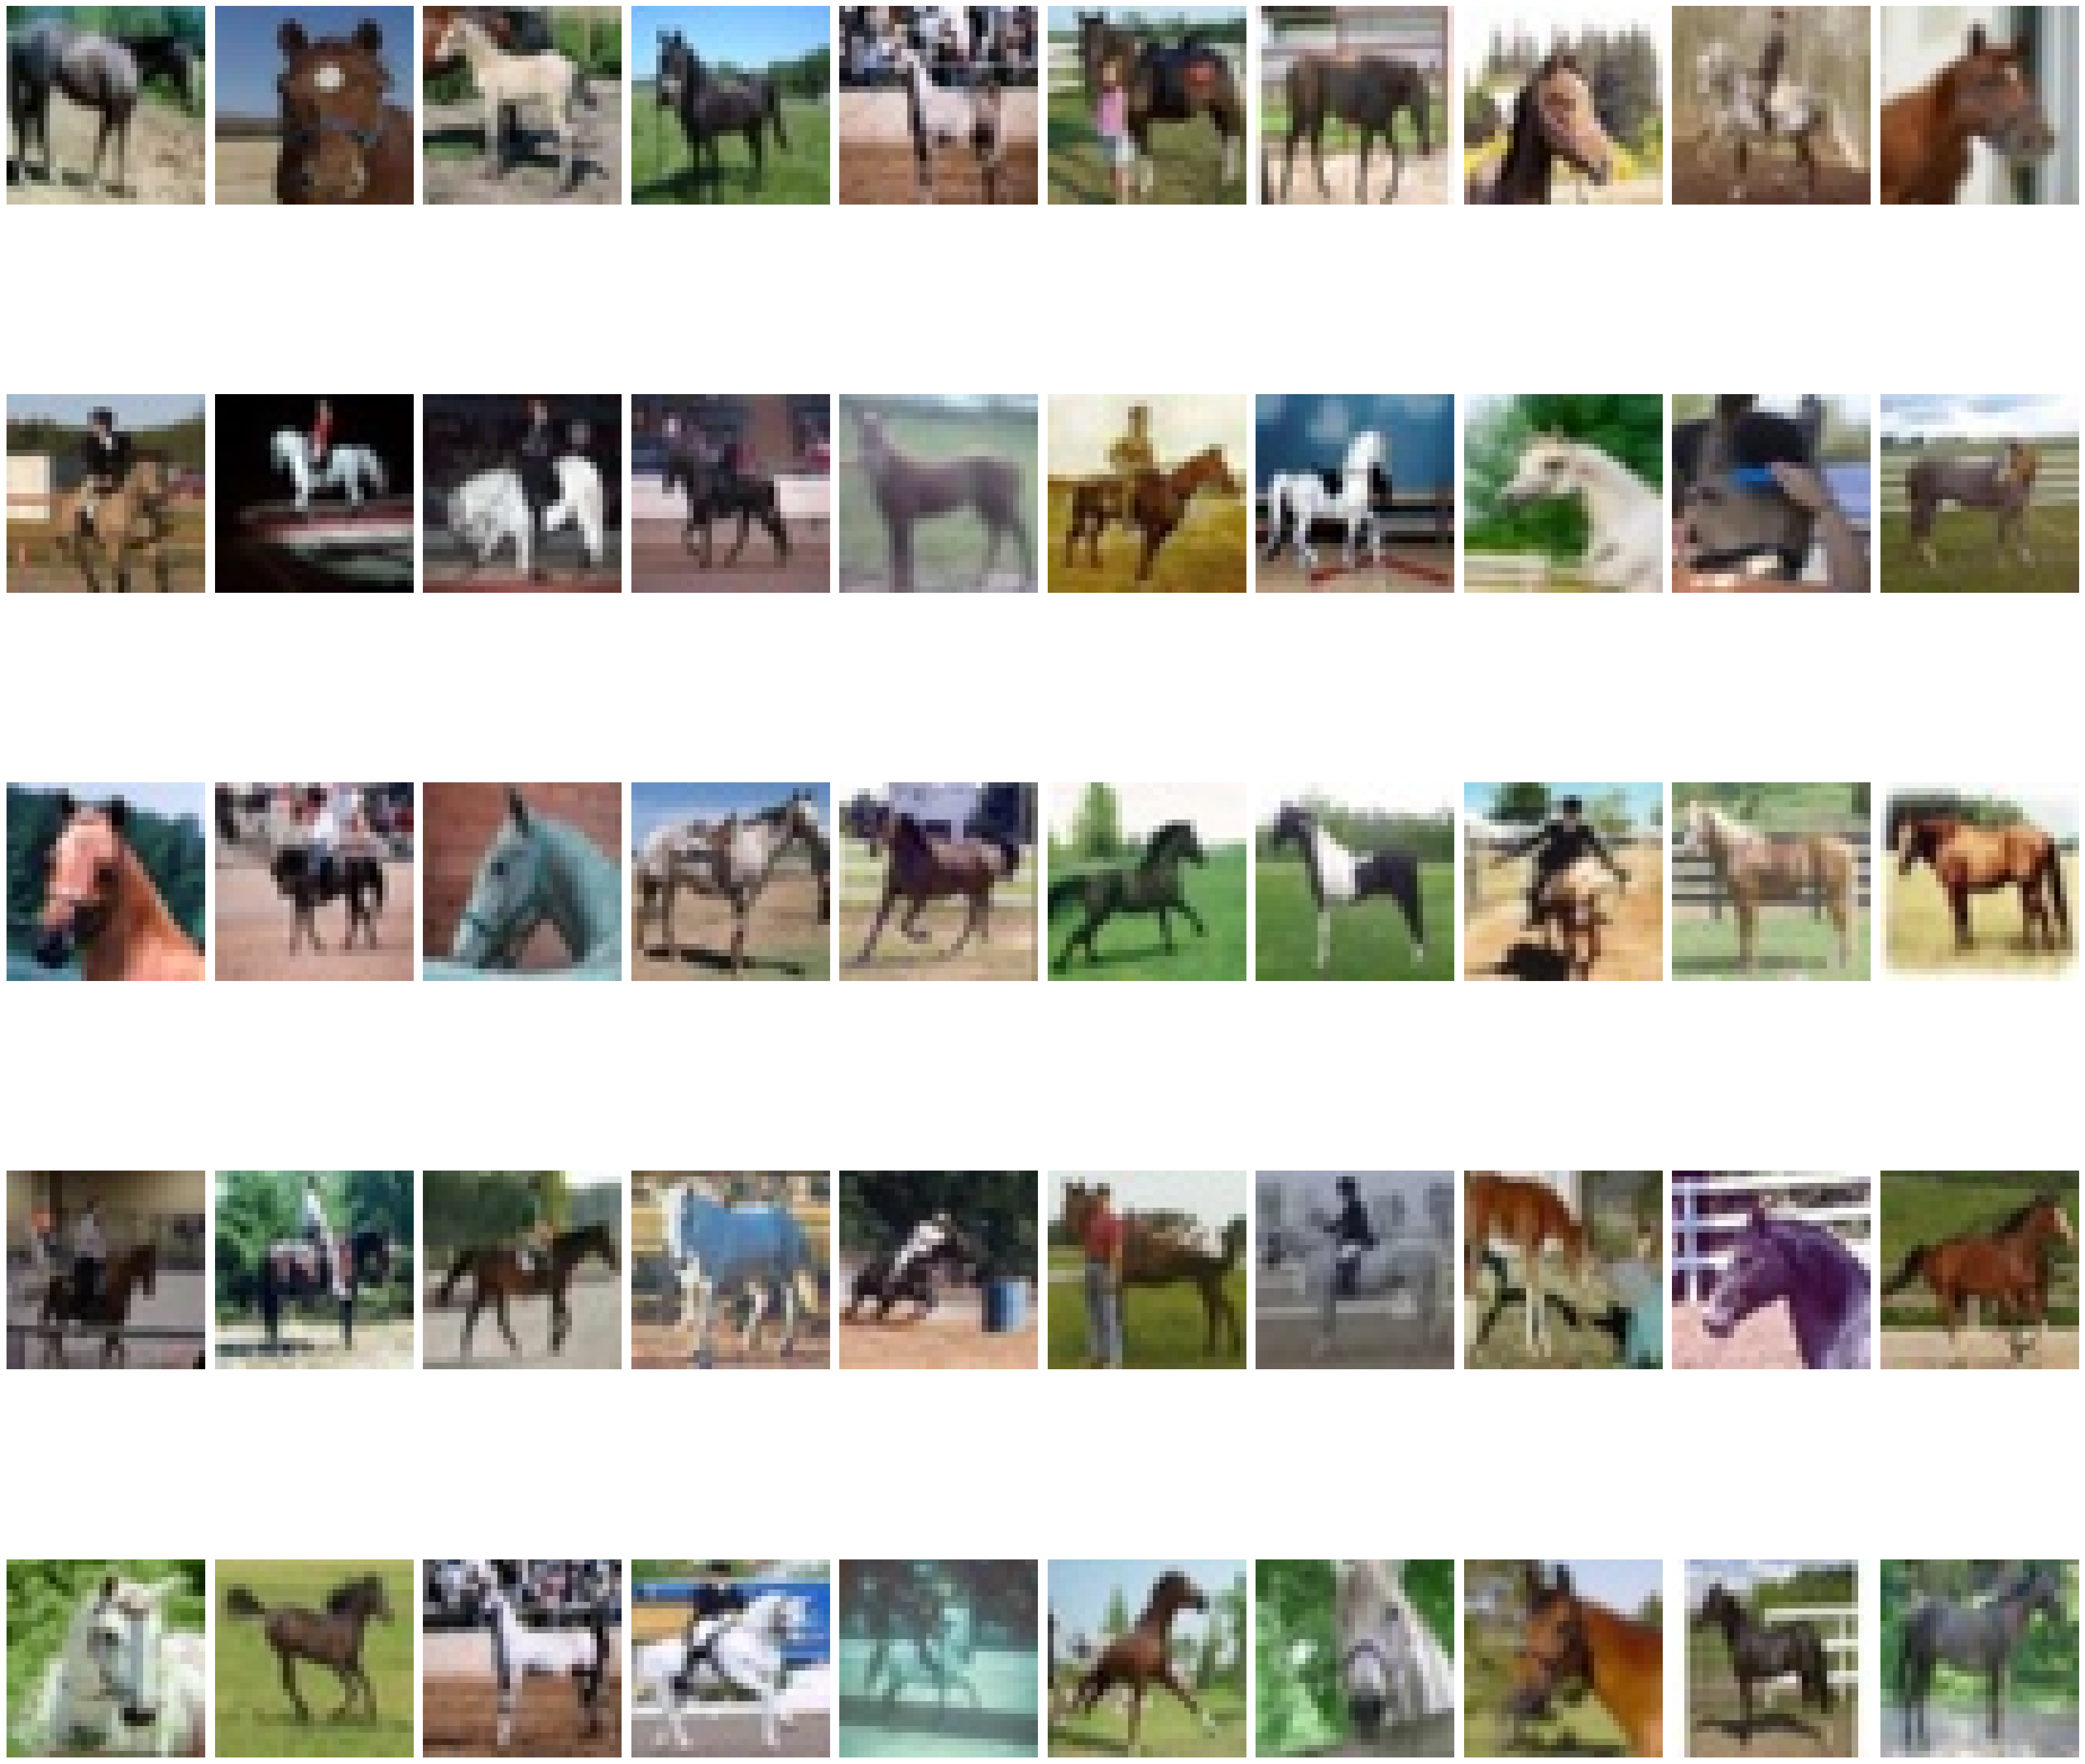

Images with label 8 : ['0019531.jpg' '001adfd.jpg' '003686e.jpg' ... 'd57b2ce.jpg' 'd596ff8.jpg'
 'd59841e.jpg']


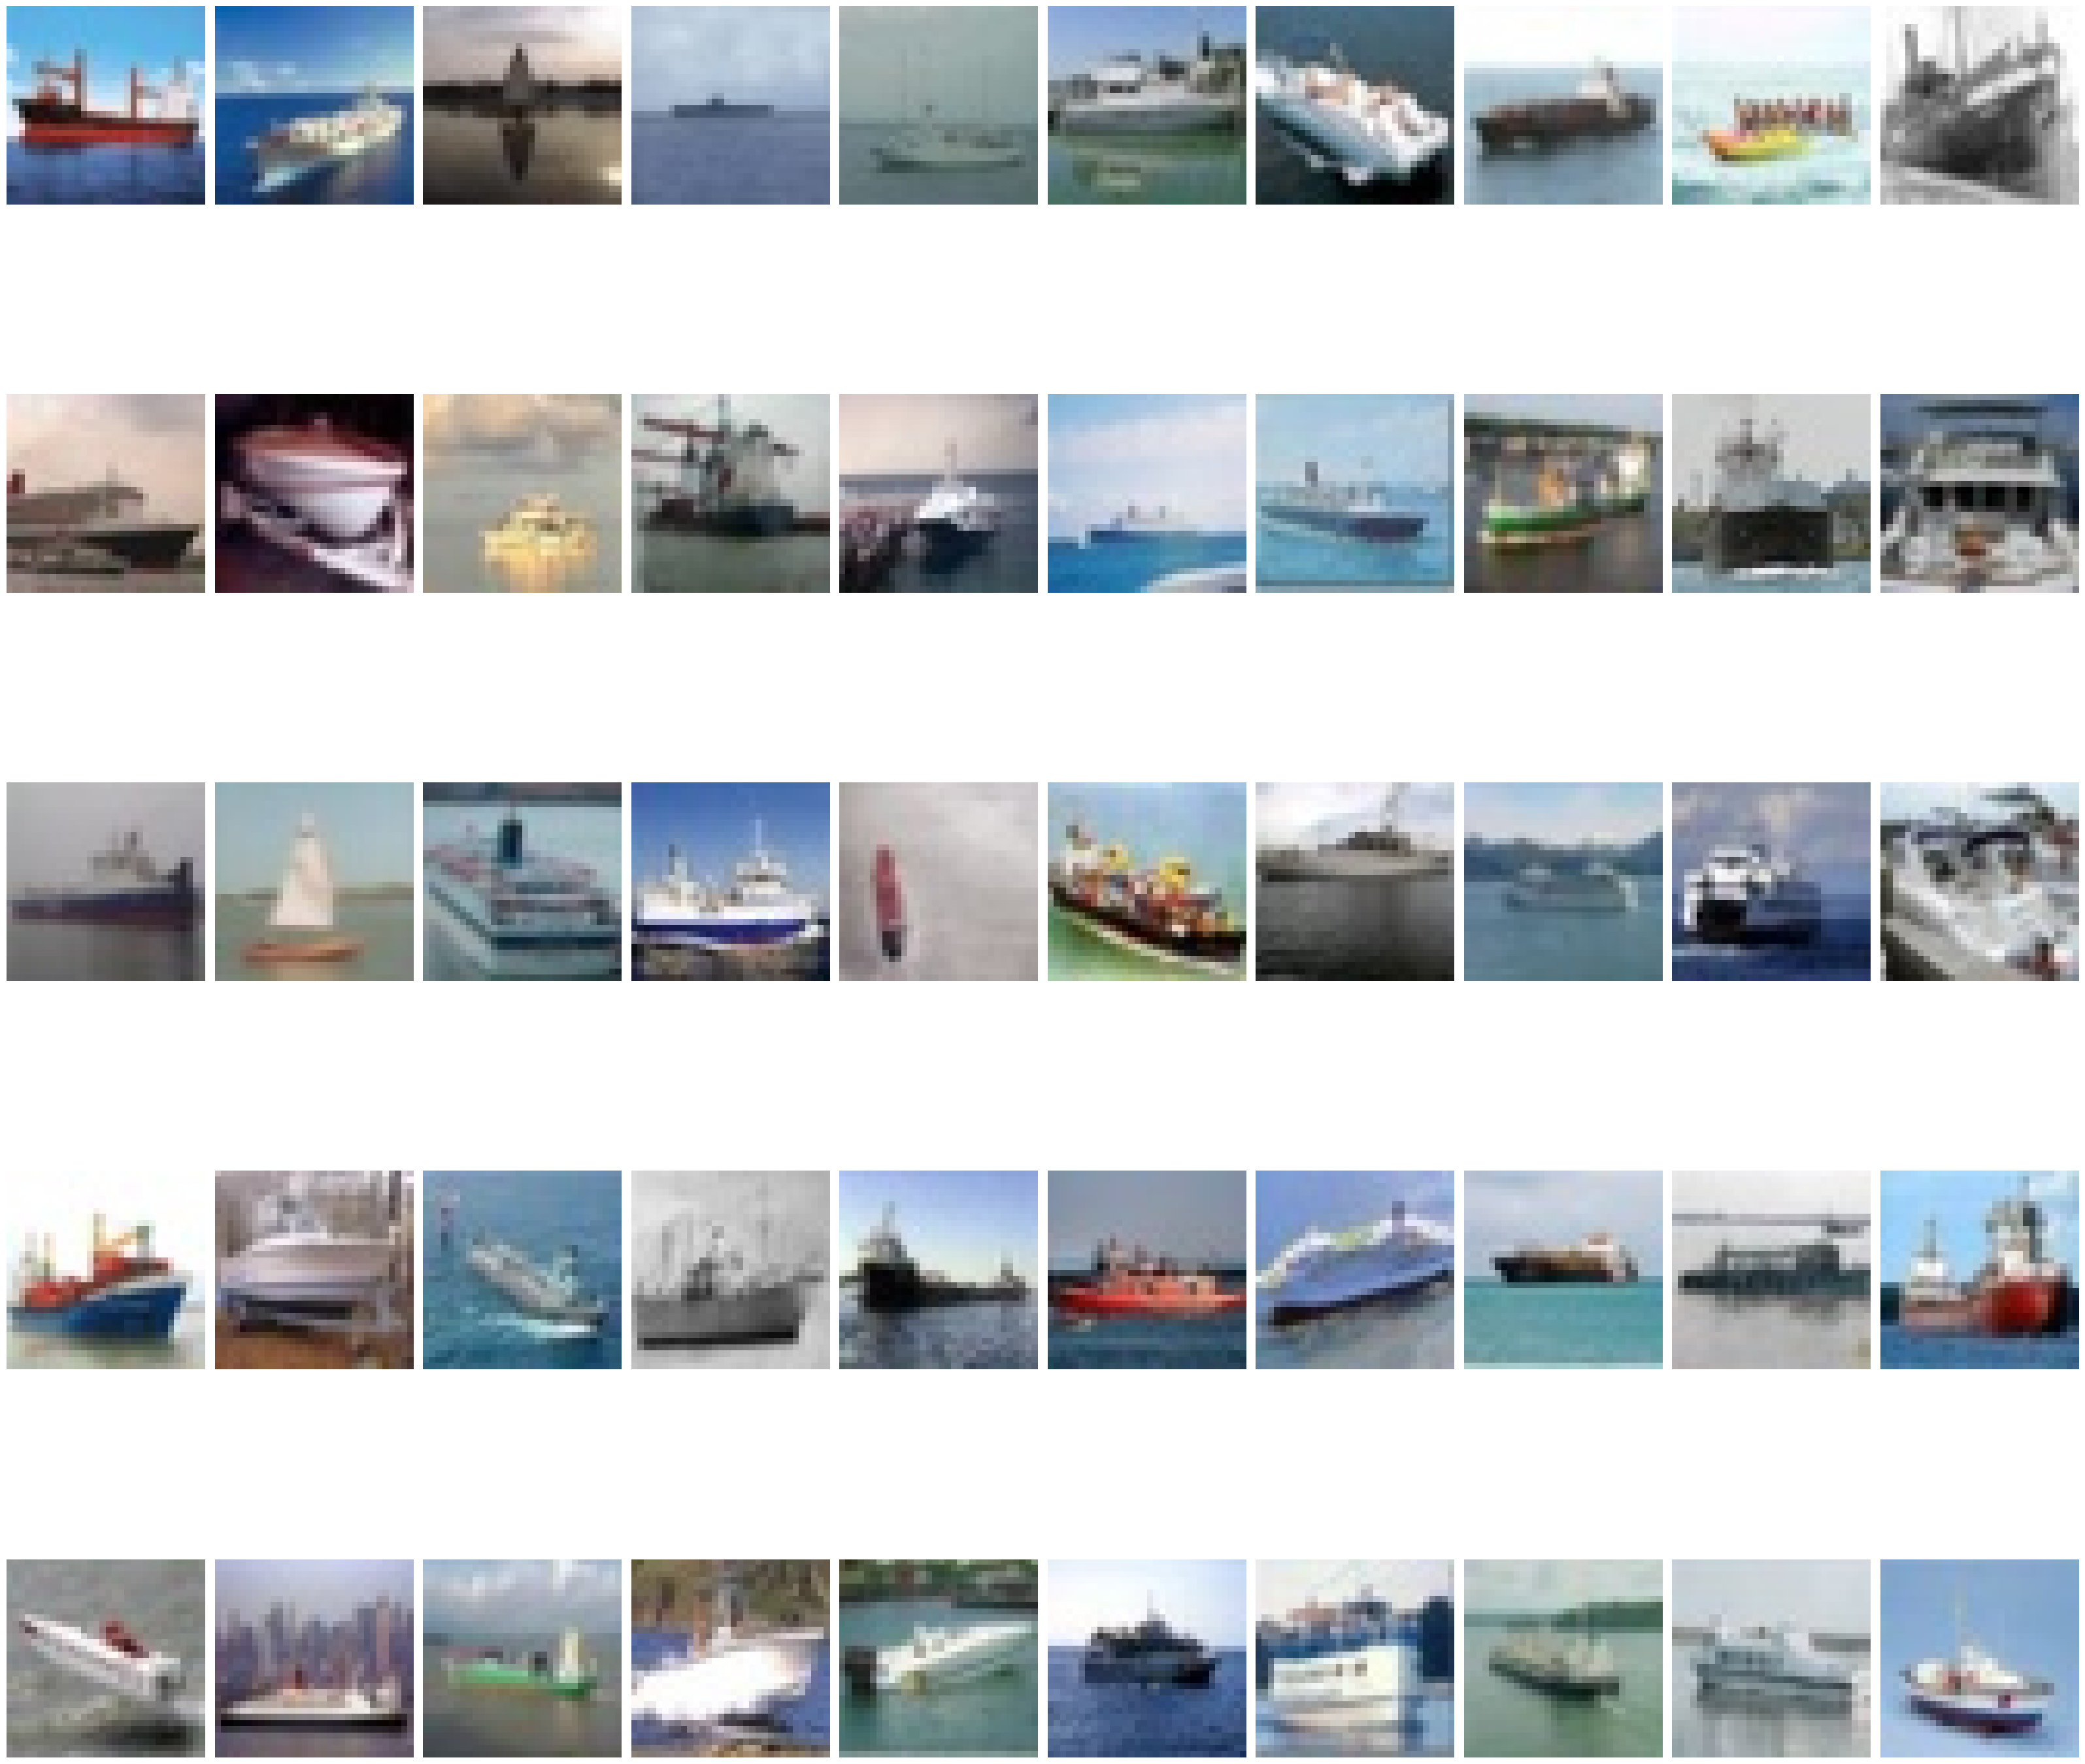

Images with label 9 : ['000edf2.jpg' '003adab.jpg' '00433dd.jpg' ... 'd597059.jpg' 'd599cf6.jpg'
 'd59c7f5.jpg']


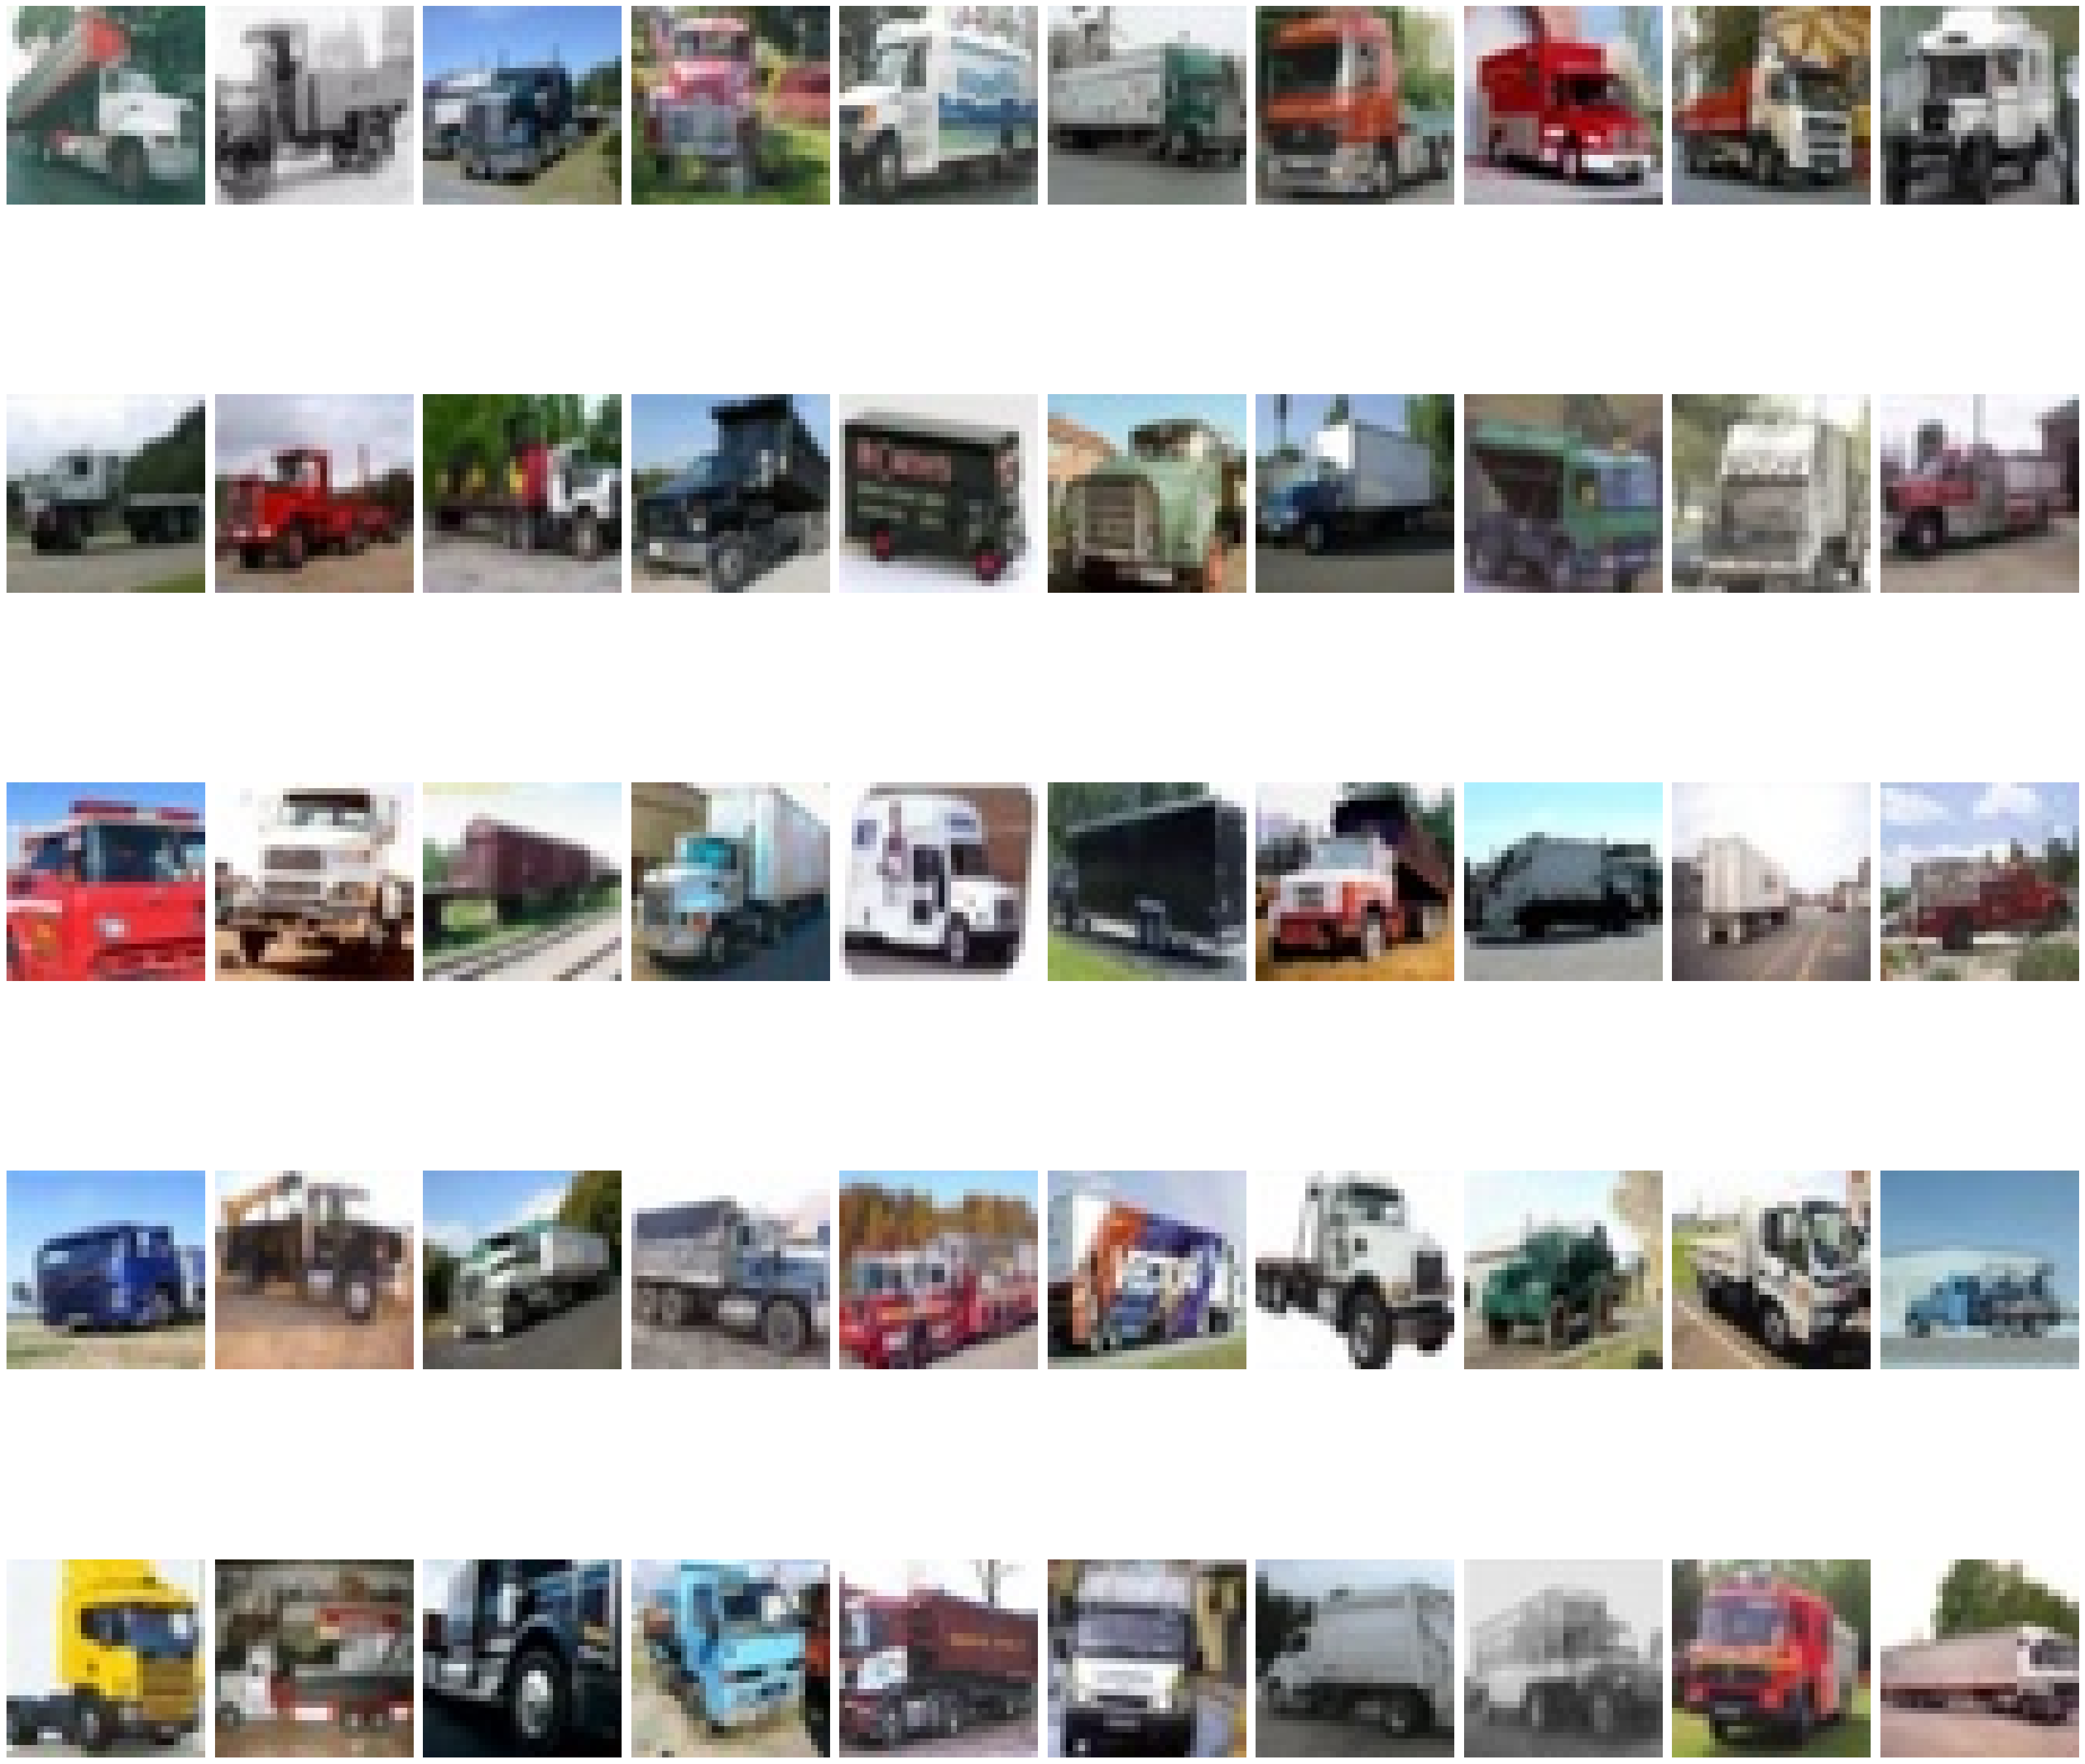

In [3]:
for i in range(10):
    index = [x == i for x in labels]
    images_names_i = np.array(image_names)[index]
    print("Images with label", i, ":", images_names_i)
    images_path = [f'./train_ims/{x}' for x in images_names_i]

    fig, axes = plt.subplots(5, 10, figsize=(32, 32))
    
    # Iterate over the image paths and display each image
    for i, ax in enumerate(axes.flat):
        img = mpimg.imread(images_path[i])
        ax.imshow(img)
        ax.axis('off')

    # Adjust the layout and spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Feature Extraction Function

In [114]:
# Histogram of Oriented Gradients (HOG)
from skimage import color
from skimage.transform import resize
import math
epsilon = 1e-5
n_clusters = 20
number_of_bins = 9
step_size = 180 / number_of_bins

def calculate_j(angle):
    temp = (angle / step_size) - 0.5
    j = math.floor(temp)
    return j

def calculate_Cj(j):
    Cj = step_size * (j + 0.5)
    return round(Cj, 9)

def calculate_value_j(magnitude, angle, j):
    Cj = calculate_Cj(j+1)
    Vj = magnitude * ((Cj - angle) / step_size)
    return round(Vj, 9)

def HOG_FeatureExtractor(img, kmean=None):
    img = color.rgb2gray(img)
    img = np.array(img)
    # print("beiginning...")
    mag = []
    theta = []
    for i in range(32):
        magnitudeArray = []
        angleArray = []
        for j in range(32):
            if j-1 <= 0 or j+1 >= 32:
                if j-1 <= 0:
                    Gx = img[i][j+1] - 0
                elif j+1 >= len(img[0]):
                    Gx = 0 - img[i][j-1]
            else:
                Gx = img[i][j+1] - img[i][j-1]
            
            if i-1 <= 0 or i+1 >= 32:
                if i-1 <= 0:
                    Gy = 0 - img[i+1][j]
                elif i+1 >= 32:
                    Gy = img[i-1][j] - 0
            else:
                Gy = img[i-1][j] - img[i+1][j]

            magnitude = math.sqrt(pow(Gx, 2) + pow(Gy, 2))
            magnitudeArray.append(round(magnitude, 9))

            if Gx == 0:
                angle = math.degrees(0.0)
            else:
                angle = math.degrees(abs(math.atan(Gy / Gx)))
            angleArray.append(round(angle, 9))
        mag.append(magnitudeArray)
        theta.append(angleArray)
    mag = np.array(mag)
    theta = np.array(theta)
    # plt.figure(figsize=(15, 8))
    # plt.imshow(img, cmap="gray")
    # plt.axis("off")
    # plt.show()
    # plt.figure(figsize=(15, 8))
    # plt.imshow(mag, cmap="gray")
    # plt.axis("off")
    # plt.show()
    # plt.figure(figsize=(15, 8))
    # plt.imshow(theta, cmap="gray")
    # plt.axis("off")
    # plt.show()
    # return 
    # print("magnitude and theta calculated")
    histogram_points_nine = []
    for i in range(0, 32, 8):
        temp = []
        for j in range(0, 32, 8):
            magnitude_values = [[mag[x][y] for y in range(j, j+8)] for x in range(i, i+8)]
            angle_values = [[theta[x][y] for y in range(j, j+8)] for x in range(i, i+8)]
            bins = [0.0 for _ in range(number_of_bins)]
            for k in range(len(magnitude_values)):
                for l in range(len(magnitude_values[0])):
                    value_j = calculate_j(angle_values[k][l])
                    Vj = calculate_value_j(magnitude_values[k][l], angle_values[k][l], value_j)
                    Vj_1 = magnitude_values[k][l] - Vj
                    bins[value_j] += Vj
                    bins[value_j+1] += Vj_1
            bins = [round(x, 9) for x in bins]
            temp.append(bins)
        histogram_points_nine.append(temp)
    # print("histogram points calculated")
    for i in range(0, len(histogram_points_nine) - 1, 2):
        for j in range(0, len(histogram_points_nine[0]) - 1, 2):
            temp = np.array([histogram_points_nine[x][y] for x in range(i, i+2) for y in range(j, j+2)]).flatten()
            mean = np.mean(temp)
            std = np.std(temp)
            for x in range(i, i+2):
                for y in range(j, j+2):
                    histogram_points_nine[x][y] = (histogram_points_nine[x][y] - mean) / (std + epsilon)
    # print("histogram points normalized")
    if kmean == None:
        return histogram_points_nine
    else:
        histogram = [0 for _ in range(n_clusters)]
        id = kmean.predict(histogram_points_nine.reshape(len(histogram_points_nine) * len(histogram_points_nine[0]), -1))
        histogram, _ = np.histogram(id, bins=n_clusters)
        return histogram / len(id)

In [5]:
# Extract the three most significant colors as features
# return (9, ) feature embedding
def TopColors_FeatureExtractor(image, num_colors):
    # Reshape the image to a flattened array of pixels
    pixels = image.reshape(-1, 3)

    # Convert the pixel values to floating point
    pixels = pixels.astype(np.float32)

    # Perform k-means clustering to extract dominant colors
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.1)
    _, labels, centers = cv2.kmeans(pixels, num_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert the color centers to the 8-bit unsigned integer format
    centers = np.uint8(centers)

    # Count the occurrences of each color
    counts = np.bincount(labels.flatten())

    # Sort the colors based on their frequency in descending order
    sorted_centers = centers[np.argsort(-counts)]
    top_colors = sorted_centers[:num_colors]
    normalized_top_colors = top_colors / 255.0
    return np.array(normalized_top_colors).reshape(-1)


In [6]:
# SIFT feature extractor
from sklearn.cluster import KMeans

sift = cv2.xfeatures2d.SIFT_create()
def SIFT_FeatureExtractor(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray_img, None)
    if descriptors is None:
        return np.array([]).reshape(0, 128)
    else:
        return descriptors

In [7]:
import mahotas as mh
def HaralickTexture_FeatureExtractor(image, num_bins=16):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute Haralick texture features
    textures = mh.features.haralick(gray)

    # Calculate the histogram of texture features
    histogram, _ = np.histogram(textures, bins=num_bins, range=(textures.min(), textures.max()+1), density=True)

    return histogram

In [8]:
# Local Binary Patterns (LBP)
from skimage.feature import local_binary_pattern
def LBP_FeatureExtractor(image, num_points=8, radius=1, num_bins=256):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize the image to 32x32
    resized = cv2.resize(gray, (32, 32))
    
    # Calculate LBP
    lbp = local_binary_pattern(resized, num_points, radius, method='uniform')
    
    # Calculate histogram of LBP image
    histogram, _ = np.histogram(lbp.ravel(), bins=num_bins, range=(0, num_bins-1), density=True)
    
    return histogram

ModuleNotFoundError: No module named 'skimage'

In [8]:
def Color_Entropy_FeatureExtractor(image, num_bins=256):
    # Convert the image to the HSV color space (hue saturation value)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Split the HSV image into individual channels
    h, s, v = cv2.split(hsv)
    
    # Calculate histograms of each color channel
    hist_h, _ = np.histogram(h, bins=num_bins, range=(0, 180), density=True)
    hist_s, _ = np.histogram(s, bins=num_bins, range=(0, 256), density=True)
    hist_v, _ = np.histogram(v, bins=num_bins, range=(0, 256), density=True)
    
    # Compute entropy of color histograms
    entropy_h = -np.sum(hist_h * np.log2(hist_h + 1e-7))
    entropy_s = -np.sum(hist_s * np.log2(hist_s + 1e-7))
    entropy_v = -np.sum(hist_v * np.log2(hist_v + 1e-7))
    
    # Combine the entropies into a single feature vector
    feature_vector = np.array([entropy_h, entropy_s, entropy_v])
    
    return feature_vector

In [9]:
def Haar_FeatureExtractor(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize the image to 32x32
    resized = cv2.resize(gray, (32, 32))
    
    # Calculate Haar-like features
    features = cv2.HaarEvaluator().compute(resized)
    
    return features

# Feature Extraction

In [113]:
from sklearn.cluster import KMeans
import random

def HOG_KNN():
    cnt = 0
    train_features = []
    for image_name in image_names:
        images_path = f'./train_ims/{image_name}'
        img = cv2.imread(images_path) # (32, 32, 3)
        # histogram_points_nine = 
        HOG_FeatureExtractor(img)

        # for i in range(len(histogram_points_nine)):
        #     for j in range(len(histogram_points_nine[0])):
        #             train_features.append(histogram_points_nine[i][j])
        cnt += 1
        if cnt % 1000 == 0:
            print("Processed", cnt, "images")
        if (cnt>2):
            break
    print("begin kmeans")
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(train_features)
    print("kmeans done")
    return kmeans

data = list(zip(image_names, labels))
random.shuffle(data)
train_names_shuffled, labels_shuffled = zip(*data)
kmean = HOG_KNN()

value_j:  1
value_j:  1
value_j:  3
value_j:  3
value_j:  3
value_j:  3
value_j:  3
value_j:  3
value_j:  1
value_j:  1
value_j:  3
value_j:  3
value_j:  2
value_j:  3
value_j:  3
value_j:  3
value_j:  -1
value_j:  -1
value_j:  3
value_j:  0
value_j:  1
value_j:  3
value_j:  1
value_j:  1
value_j:  -1
value_j:  -1
value_j:  3
value_j:  0
value_j:  0
value_j:  2
value_j:  0
value_j:  3
value_j:  -1
value_j:  -1
value_j:  0
value_j:  0
value_j:  -1
value_j:  -1
value_j:  2
value_j:  -1
value_j:  -1
value_j:  -1
value_j:  1
value_j:  3
value_j:  1
value_j:  2
value_j:  2
value_j:  2
value_j:  -1
value_j:  -1
value_j:  -1
value_j:  0
value_j:  0
value_j:  0
value_j:  3
value_j:  3
value_j:  -1
value_j:  -1
value_j:  -1
value_j:  3
value_j:  3
value_j:  1
value_j:  0
value_j:  1
value_j:  3
value_j:  3
value_j:  3
value_j:  3
value_j:  3
value_j:  3
value_j:  3
value_j:  3
value_j:  3
value_j:  3
value_j:  3
value_j:  3
value_j:  3
value_j:  3
value_j:  3
value_j:  3
value_j:  0
value_j:  1

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [100]:
labels = np.array(labels)

image_features = []

cnt = 0
for image_name in image_names:

    images_path = f'./train_ims/{image_name}'
    image = cv2.imread(images_path)
    
    HOG_feature = HOG_FeatureExtractor(image, kmean)
    
    features = np.concatenate((HOG_feature,), axis=0)
    
    image_features.append(features)

    if (cnt % 1000 == 0):
        print("Processed", cnt, "images")
    cnt += 1

image_features = np.array(image_features)

train_images, test_images, train_labels, test_labels = train_test_split(
    image_features, labels, test_size=0.2, random_state=42
)

Processed 0 images
Processed 1000 images
Processed 2000 images
Processed 3000 images
Processed 4000 images
Processed 5000 images
Processed 6000 images
Processed 7000 images
Processed 8000 images
Processed 9000 images
Processed 10000 images
Processed 11000 images
Processed 12000 images
Processed 13000 images
Processed 14000 images
Processed 15000 images
Processed 16000 images
Processed 17000 images
Processed 18000 images
Processed 19000 images
Processed 20000 images
Processed 21000 images


KeyboardInterrupt: 

# Classifier

In [12]:
# LinearSVC
from sklearn.svm import LinearSVC
model = LinearSVC(multi_class='ovr', max_iter=3000, C=1, gamma=0.1)
model.fit(train_images, train_labels)

TypeError: __init__() got an unexpected keyword argument 'gamma'

In [96]:
# kernel SVC
from sklearn.svm import SVC
model = SVC(kernel='rbf', max_iter=10000)
model.fit(train_images, train_labels)

SVC(max_iter=10000)

In [54]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression
Logis_model = LogisticRegression(C=1)
Logis_model.fit(train_images, train_labels)

/Users/bowieshi/anaconda3/envs/bowie/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5722

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(train_images, train_labels)

RandomForestClassifier(random_state=42)

# Evaluation

In [97]:
# Evaluate the model on the test dataset
predictions = model.predict(test_images)
accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracy}")

# Save the SVM model parameters to a file
filename = 'svm_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

Accuracy: 0.3068


# New Classifier

In [33]:
# kernel SVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
print("train_images:", train_images.shape)
data = list(zip(train_images, train_labels))
random.shuffle(data)
train_images_shuffled, train_labels_shuffled = zip(*data)
train_images_shuffled = np.array(train_images_shuffled)
train_labels_shuffled = np.array(train_labels_shuffled)
print("train_images_shuffled:", train_images_shuffled.shape)
model = [SVC(kernel='rbf', max_iter=3000) for i in range(10)]
for i in range(10):
    index_i = [x == i for x in train_labels_shuffled]
    index_not_i = [x != i for x in train_labels_shuffled]
    train_images_i = train_images_shuffled[index_i]
    train_images_not_i = train_images_shuffled[index_not_i]
    # print("Number of images with label", i, ":", train_images_i.shape[0], train_images_not_i.shape[0])
    new_train_images = np.concatenate((train_images_i, train_images_not_i), axis=0)
    new_train_labels = np.concatenate((np.ones(train_images_i.shape[0]), np.zeros(train_images_not_i.shape[0])), axis=0)
    # print("new_train_images:", new_train_images)
    # print("new_train_labels:", new_train_labels)
    model[i].fit(new_train_images, new_train_labels)
    print("Model", i, "trained")
    break

train_images: (40000, 5184)
train_images_shuffled: (40000, 5184)
Model 0 trained


/Users/bowieshi/anaconda3/envs/bowie/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [34]:
# Evaluate the model on the test dataset
data = list(zip(test_images, test_labels))
random.shuffle(data)
test_images_shuffled, test_labels_shuffled = zip(*data)

index_i = [x == i for x in test_labels]
index_not_i = [x != i for x in test_labels]
test_images_i = test_images[index_i]
test_images_not_i = test_images[index_not_i]
new_test_images = np.concatenate((test_images_i, test_images_not_i), axis=0)
new_test_labels = np.concatenate((np.ones(test_images_i.shape[0]), np.zeros(test_images_not_i.shape[0])), axis=0)

predictions = model[0].predict(test_images)
accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracy}")

# Save the SVM model parameters to a file
filename = 'svm_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

Accuracy: 0.0455
